In [1]:
import pandas as pd
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [3]:
mainpath = "/Users/soldash/Documents/Tesis/python/Datos/" #ruta de Carga de los datos
filename = "lslr PARTE 1 DE 6 CRISIS.m00" #Nombre del archivo a cargar

In [3]:
%%time 
#cuenta el tiempo en realizar la casilla
data = pd.read_csv(mainpath+filename, sep="\s+", skiprows=[0], usecols = ['X1-X2']) #Lectura de archivos con parametros
#data = pd.read_csv(mainpath+filename, sep="\s+", skiprows=[0], usecols = ['X1-X2'], nrows=10000) #cargar solo primeras 1000 filas
data["X1-X2"] = - data["X1-X2"] #Invertir la señal ya que esta viene invertida

Date = "2022/07/01" #Establecer la fecha de las muestras, puede ser cualquiera, solo se usa como referencia
datatitle = open(mainpath + filename,"r")#Abrir en memoria solo en lectura (read)
info = datatitle.readline().strip().split(" ") #lee la primera linea en datatitle y lo ubica en un arreglo
print(info)
StartHour = info[len(info)-1].split("=") #toma la ultima posición del arreglo (el tiempo de Inicio) lo separa por el igual
StartDate= datetime.strptime(Date + " "+ StartHour[1], '%Y/%m/%d %H:%M:%S') #convierte el tiempo iniciar en una tipo de dato fecha
print(StartDate)

#Crea el un dataframe de fechas con frecuencia de 2ms iniciando de la fecha inicial
df_times = pd.date_range(start=StartDate, periods= len(data), freq = '2ms')
data["Time"] = df_times #Lo ubica en la columna time
data.rename(columns={'X1-X2':'ECG'},inplace=True)

data["Seizure"] = 0
data["RRI"] = 0
data["SDNN"] = 0
data["HR"] = 0
data["HR_std"] = 0
data["NN50"] = 0
data["pNN50"] = 0
data["HF"] = 0
data["LF"] = 0
data["Total_power"] = 0
data["LF/HF"] = 0

data

NameError: name 'mainpath' is not defined

# Marcar las Crisis

Función para marcar la columna Seizure como una crisis


Parametros:

* df = data frame de la muestra
* start_date = fecha de inicio
* end_date = fecha final


estados variable a predecir

* normal -> 0 /1 
* pre-ictal -> 500 /2 (clase a predecir)
* ictal -> 1000 /3 



In [5]:
def putSeilzure(df, start_date, end_date):
    start_date = int(data[data["Time"] == start_date].index[0])
    
    preictal_date = start_date - 60000
    
    end_date = int(data[data["Time"] == end_date].index[0])

    data.loc[preictal_date: start_date,"Seizure"] = 50
    data.loc[start_date: end_date,"Seizure"] = 100

    
#Función para marcar las crisis sin grafico.

#Crisis 1:
putSeilzure(data,"2022-07-01 07:51:51.000000", "2022-07-01 07:51:59.000000")
#Crisis 2:
putSeilzure(data,"2022-07-01 07:57:59.000000", "2022-07-01 07:58:08.000000")
#Crisis 3:
putSeilzure(data,"2022-07-01 08:00:17.000000", "2022-07-01 08:00:25.000000")
#Crisis 4:
putSeilzure(data,"2022-07-01 08:03:42.000000", "2022-07-01 08:03:53.500000")
#Crisis 5:
putSeilzure(data,"2022-07-01 12:29:35.000000", "2022-07-01 12:29:47.000000")

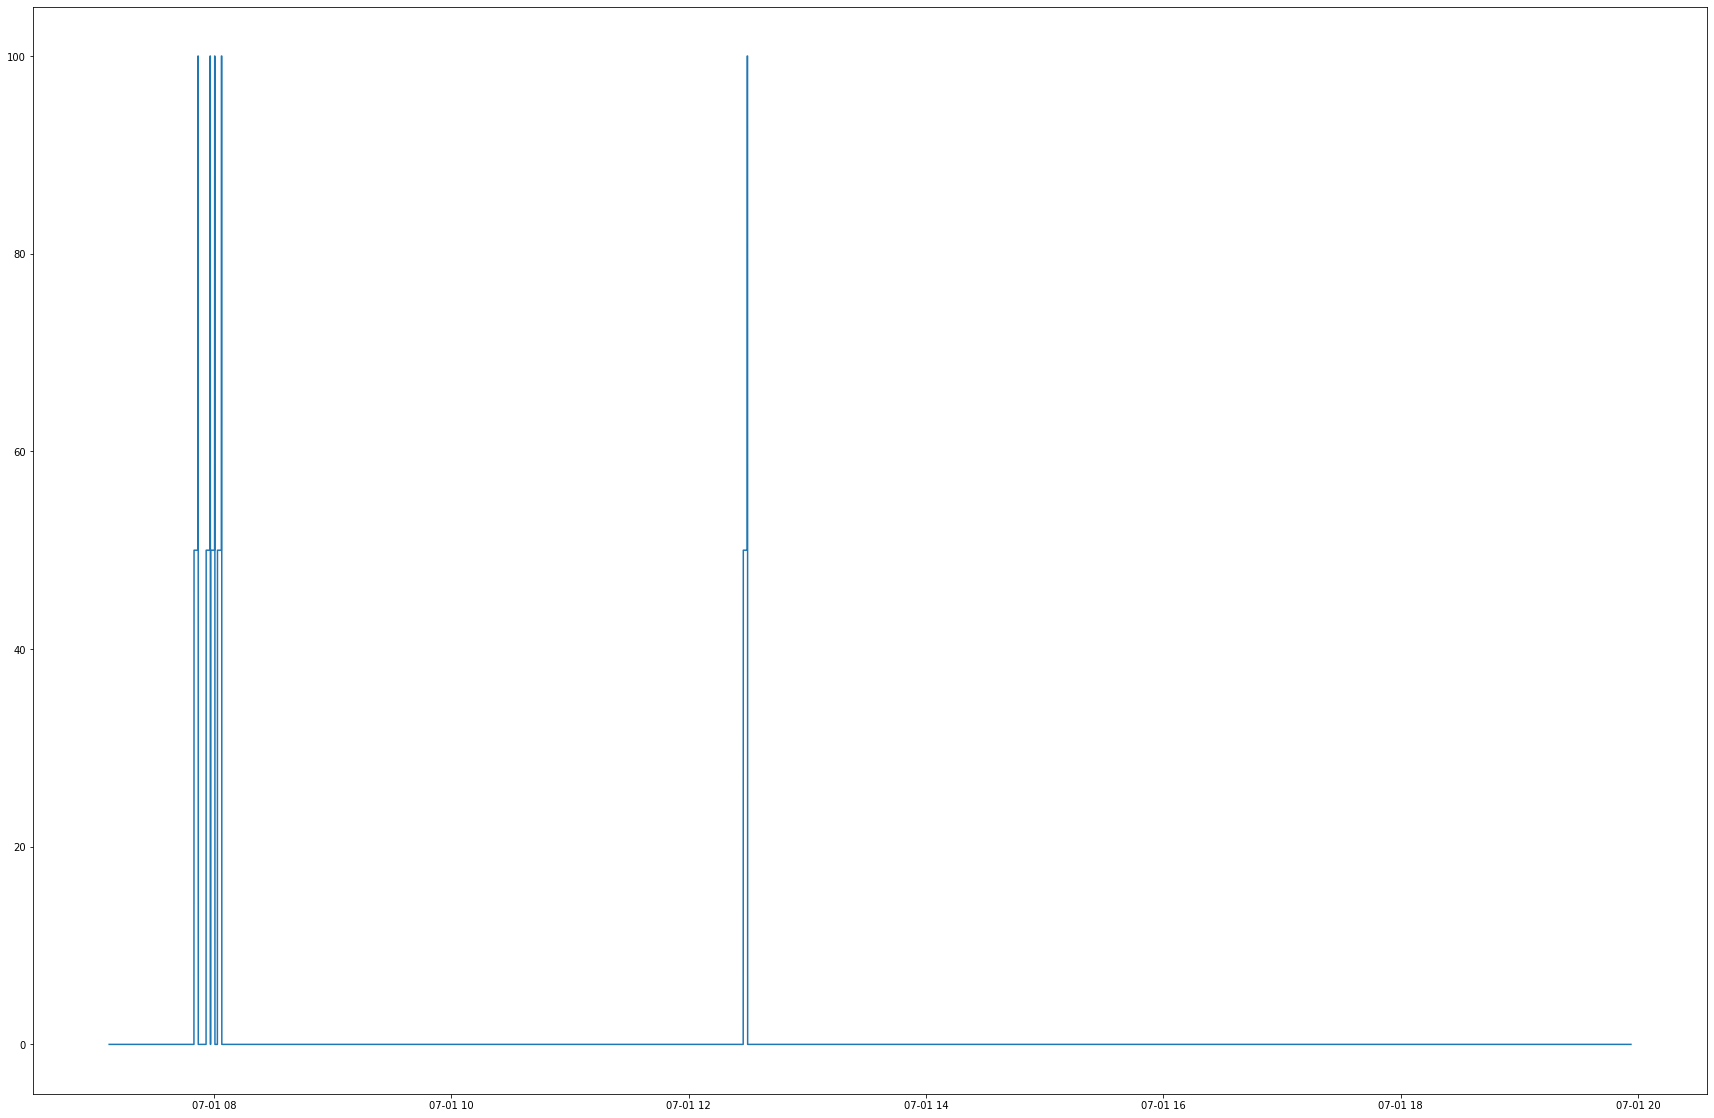

In [56]:
plt.figure(figsize=(30,20))
plt.plot(data["Time"], data["Seizure"])

## Prueba para insertar RRI

Se utilizará el siguiente codigo para poder realizar desarrollos sobre una parte del codigo sin necesidad de esperar procesamientos largos en toda la muestra

In [2]:
%%time
import numpy as np
import pyhrv.frequency_domain as fd
import pyhrv.time_domain as td

pd.options.mode.chained_assignment = None  # default='warn'

def seconds_to_samples(x):
    return int(x*1000)/2 
    

#Tiempos de pruebas para evitar procesamiento largo
#ts = "2022-07-01 07:49:51"
ts = "2022-07-01 12:27:00"
print("Tiempo inicial: "+ts)
interval = 300000#tiempo en ms
tf = None;

#Definir valor en segundos
delta_window = 15
HR_window=30 #15000 = 30 segundos ventana de 1 minuto
frecuency_window = 60

#Se dividen en la frecuencia de muestreo 2 ms
delta_window = seconds_to_samples(delta_window)
HR_window=seconds_to_samples(HR_window)
frecuency_window = seconds_to_samples(frecuency_window)
#----#

fbands = {'ulf': (0.0, 0.1), 'vlf': (0.1, 0.2), 'lf': (0.2, 0.3), 'hf': (0.3, 0.4)}

ts = int(data[data["Time"] == ts].index[0])
interval = int(interval / 2) #como la señal esta muestreada a 2ms se divide para encontrar el tiempo adecuado
tf = ts + interval

print("Tiempo final:   "+str(data.loc[tf]["Time"]))
print("Indice inicial: "+str(ts))
print("Indice final:   "+str(tf))
#Se toma el intervalo de interés
sampleDf = data[ts:tf]

#Hallar los picos
peaks, properties = find_peaks(sampleDf["ECG"], prominence=[300,8000], width=1,distance = 120)
#Ajustar los picos al tiempo de la muestra
peaks = peaks+ts

time_RRI = []

for i in range(len(peaks)):
    if i != 0:
        #RRI
        
        #print("valor inicial: "+str(sampleDf["Time"][peaks[i]]))
        #print("valor final:   "+str(sampleDf["Time"][peaks[i-1]]))
        RRI = sampleDf["Time"][peaks[i]] - sampleDf["Time"][peaks[i-1]] #Calcula distancia entre el pico y el pico anterior
        #print("diferencia en ms: "+str(RRI))                                       
        RRI = (RRI.microseconds + (RRI.seconds * 1000000))/1000 #Convierte el valor a ms
        #print("RRI "+ str(i)+ " = "+ str(RRI) + " ms")
        time_RRI.append(RRI) #se agrega al arreglo de valores RRI
        sampleDf.loc[peaks[i-1]:peaks[i], ("RRI")] = RRI #Se quita debido a que estaba afectando la muestra original



for i in range(sampleDf.index.start,sampleDf.index.stop, 100):

    #SDNN
    startWindow = i - int(delta_window)
    finishWindow = i + int(delta_window)
    if startWindow > ts and  finishWindow < tf:
        window = sampleDf.loc[startWindow:finishWindow]
        window.drop_duplicates(subset ="RRI", keep = 'last', inplace = True)
        window = window[window["RRI"] > 0]
        sampleDf["SDNN"][i] = window.std()["RRI"]
        #NN50 y pNN50
        resultNN50 = td.nn50(window["RRI"])
        sampleDf["NN50"][i] = resultNN50["nn50"]
        sampleDf["pNN50"][i] = resultNN50["pnn50"]
            
    #HR
    startHR = i - int(HR_window) 
    finishHR = i + int(HR_window)
    if startHR > ts and  finishHR < tf:
        sampleDf["HR"][i]=len(peaks[(peaks > startHR) & (peaks < finishHR)])
    
    #Frecuencia
    startWindow = i - int(frecuency_window)
    finishWindow = i + int(frecuency_window)
    if startWindow > ts and  finishWindow < tf:
        window = sampleDf.loc[startWindow:finishWindow]
        window.drop_duplicates(subset ="RRI", keep = 'last', inplace = True)
        window = window[window["RRI"] > 0]
        result = fd.welch_psd(window["RRI"], mode='dev', fbands=fbands)
        sampleDf["HF"][i] = result[0]["fft_abs"][3]
        sampleDf["LF"][i] = result[0]["fft_abs"][2]
        sampleDf["Total_power"][i] = result[0]["fft_total"]
        sampleDf["LF/HF"][i] = result[0]["fft_ratio"]
    

    
for i in range(sampleDf.index.start,sampleDf.index.stop, 100):
    startWindow = i - int(delta_window)
    finishWindow = i + int(delta_window)
    #HR_std
    if startWindow > (ts + HR_window) and  finishWindow < (tf - HR_window):
        window = sampleDf.loc[startWindow:finishWindow]
        window = window[window["HR"] > 0]
        sampleDf["HR_std"][i] = window.std()["HR"]


    
        
#Grafica los RRI
plt.figure(figsize=(25,15))       
plt.title("RRI")
plt.plot(time_RRI,"o")
plt.xlabel("# Samples")
plt.ylabel("RRI[ms]")

#Grafica la señal con los picos detectados
plt.figure(figsize=(25,15))
plt.title("ECG Signal")
fig1 = plt.plot(sampleDf["Time"],sampleDf["ECG"])
fig1 = plt.plot(sampleDf["Time"][peaks],sampleDf["ECG"][peaks], "x")
fig1 = plt.plot(sampleDf["Time"],sampleDf["RRI"], "-")
fig1 = plt.plot(sampleDf["Time"],sampleDf["SDNN"])
fig1 = plt.plot(sampleDf["Time"],sampleDf["HR"])
fig1 = plt.plot(sampleDf["Time"],sampleDf["HR_std"])
fig1 = plt.plot(sampleDf["Time"],sampleDf["Seizure"]*30, linewidth='2', color="purple")
fig1 = plt.gca().legend(('ECG','peaks',"RRI","SDNN","HR","HR_std","Seizure"),prop={'size': 20})
#fig1 = plt.vlines(x=sampleDf["Time"][peaks], ymin=data["ECG"][peaks] - properties["prominences"],ymax = data["ECG"][peaks], color = "C1")


# plt.xlabel("Date") 
# plt.ylabel("[uV]")
#display(sampleDf.to_string())


Tiempo inicial: 2022-07-01 11:53:26


NameError: name 'data' is not defined

In [54]:
#Igualar las muestras en cantidad
sampleDf =sampleDf[(sampleDf["RRI"] > 0) & (sampleDf["HR"] > 0) & (sampleDf["LF/HF"] > 0)] #Quita muestras nulas en ventanas

print(sampleDf[sampleDf["Seizure"] == 100].shape[0])
print(sampleDf[sampleDf["Seizure"] == 50].shape[0])
print(sampleDf[sampleDf["Seizure"] == 0].shape[0])

61
474
364


In [55]:
sample_size = 61

seilzure = sampleDf[sampleDf["Seizure"] == 100]
preictal = sampleDf[sampleDf["Seizure"] == 50]
reposo = sampleDf[sampleDf["Seizure"] == 0]

seilzure_data = seilzure.sample(n= sample_size)
preictal_data = preictal.sample(n= sample_size)
reposo_data = reposo.sample(n= sample_size)
    
exportSample = pd.concat([seilzure_data, preictal_data, reposo_data], axis = 0)
# exportSample = sampleDf[(sampleDf["RRI"] > 0) & (sampleDf["HR"] > 0) & (sampleDf["LF/HF"] > 0)]
exportSample.to_csv(mainpath+"out2.csv")

## Concatenar salidas

In [59]:
data1 = pd.read_csv(mainpath+"out1.csv", sep=",", sk)
data1

,Unnamed: 0,ECG,Time,Seizure,RRI,SDNN,HR,HR_std,NN50,pNN50,HF,LF,Total_power,LF/HF
0,1530900,-17.26,2022-07-01 07:58:00.800,100,1118,294.399416,60,0.987113,26,78.787879,1806.386351,2144.329428,77686.620915,1.187082
1,1601500,-1093.80,2022-07-01 08:00:22.000,100,640,349.446434,65,1.114464,28,71.794872,4323.633121,8650.637887,123461.697297,2.000780
2,1702900,-1012.83,2022-07-01 08:03:44.800,100,760,307.259757,65,0.611949,22,61.111111,4540.296126,6773.373350,91472.510768,1.491835
3,1702200,-161.95,2022-07-01 08:03:43.400,100,1132,315.223453,65,0.604764,21,60.000000,4511.669394,6748.176764,91566.467305,1.495716
4,1347600,122.73,2022-07-01 07:51:54.200,100,870,296.211090,64,1.677457,30,81.081081,6561.459292,13006.546708,90936.121891,1.982264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,1950900,8.54,2022-07-01 08:12:00.800,0,1160,125.708234,56,0.514599,20,80.000000,1899.352507,5462.059554,13909.755437,2.875748
554,1963500,-201.53,2022-07-01 08:12:26.000,0,1132,136.066024,57,0.538168,18,66.666667,941.598063,5408.378452,14064.546435,5.743829
555,2255800,-8.16,2022-07-01 08:22:10.600,0,1124,263.377895,58,0.637946,21,77.777778,3962.265751,11263.275160,31994.303765,2.842635
556,1390800,170.82,2022-07-01 07:53:20.600,0,1298,143.225282,50,2.141197,20,76.923077,4446.874455,6573.259447,27194.178940,1.478175


In [11]:
seilzure.describe()

,ECG,Seizure,RRI,SDNN,HR,HR_std,NN50,pNN50,HF,LF,Total_power,LF/HF
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
preictal.describe()

,ECG,Seizure,RRI,SDNN,HR,HR_std,NN50,pNN50,HF,LF,Total_power,LF/HF
count,2099.00000,2099.0,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000
mean,-2.83727,50.0,1153.584564,165.795369,55.745117,1.734232,19.154359,74.121627,2881.628863,4548.648751,36579.625224,1.673837
std,120.87808,0.0,145.131803,62.012264,4.909798,1.530955,3.146713,8.500676,1327.185458,2189.970322,23569.591766,0.599106
min,-947.72000,50.0,240.000000,94.369789,47.000000,0.445433,11.000000,50.000000,1136.756224,1655.288505,14974.112948,0.611531
25%,-32.79000,50.0,1040.000000,128.482815,52.000000,0.587057,17.000000,68.181818,1693.883198,2871.399569,20477.942588,1.335943
50%,-0.15000,50.0,1176.000000,141.118870,54.000000,0.941184,19.000000,76.000000,2486.791716,3885.183353,25002.272074,1.565768
75%,34.53500,50.0,1278.000000,192.629411,58.000000,2.781839,21.000000,80.000000,3940.711605,5878.738717,46060.686434,1.982514
max,1122.78000,50.0,1426.000000,373.282723,67.000000,5.882957,28.000000,92.592593,6593.268378,12702.235226,118870.134573,4.174596


# Muestra Completa 

Se hace lo anterior para la muestra completa sin intervalos

[    7385     7867     8472 ... 23083426 23083857 23084289]
49394
7678.0
5020.0


Text(0, 0.5, '[uV]')

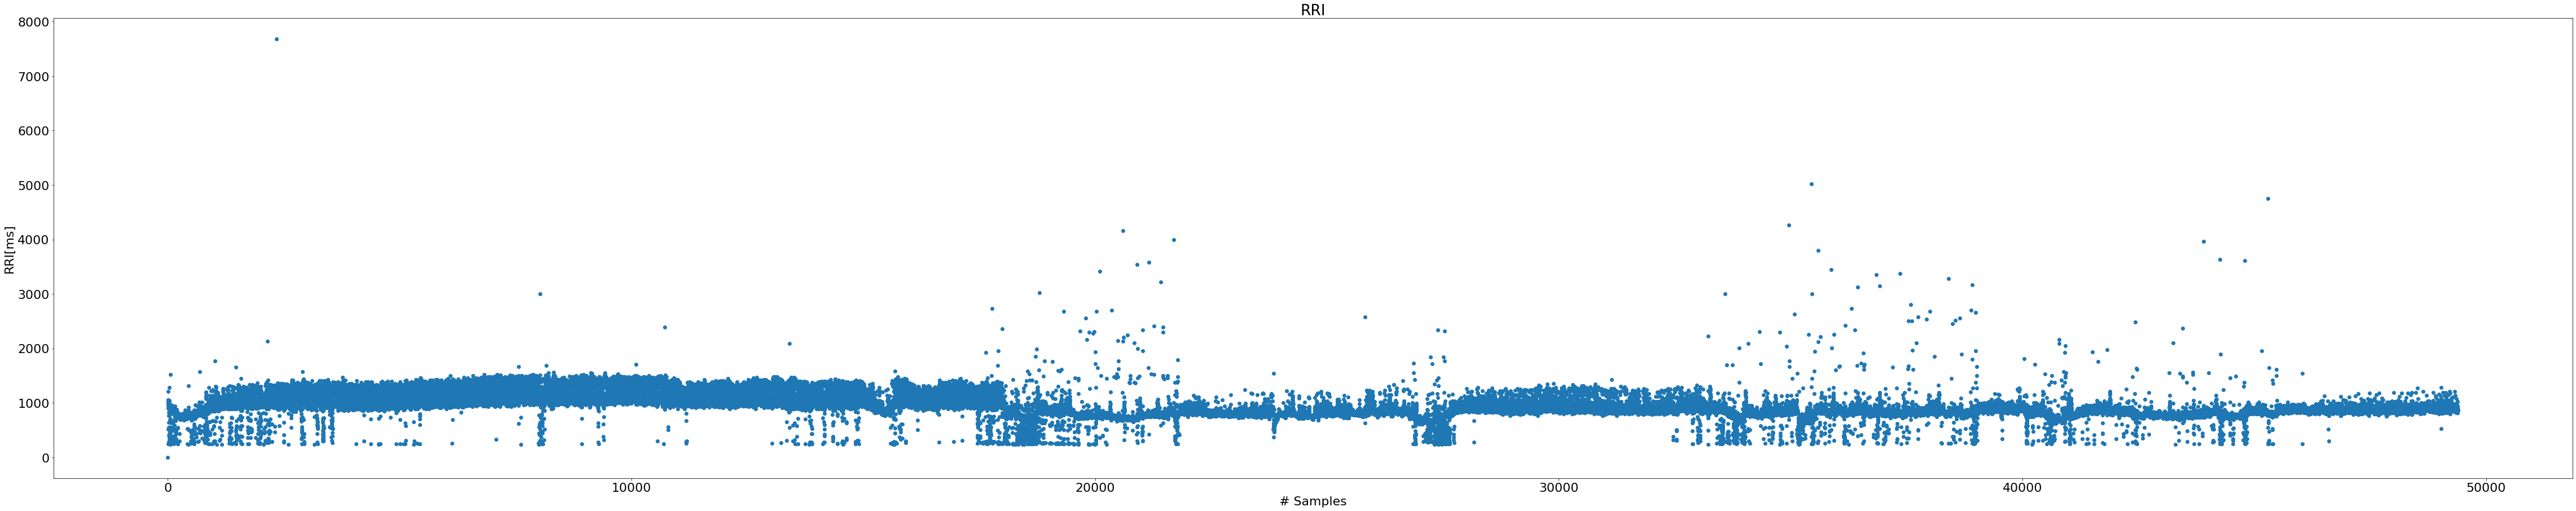

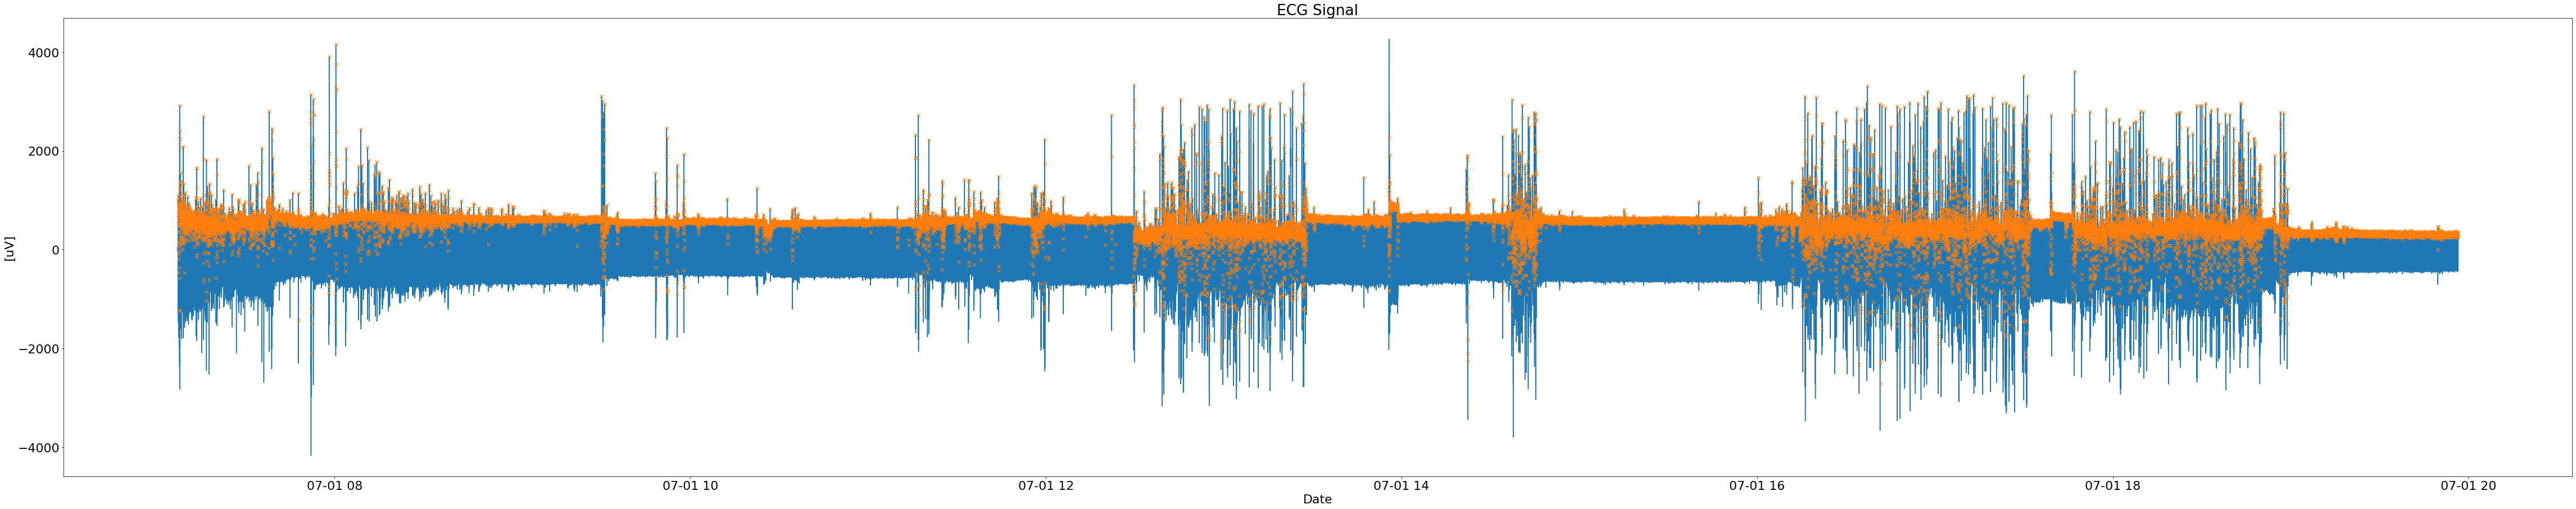

In [57]:
plt.rcParams.update({'font.size': 22})


peaks, _ = find_peaks(data["ECG"], prominence=[300,8000], width=1, distance = 120)
peaks = peaks

print(peaks)
print(len(peaks))
RRIs = [0]

for i in range(len(peaks)):
    if i != 0:
        RRI = data["Time"][peaks[i]] - data["Time"][peaks[i-1]]     
        RRI = (RRI.microseconds + (RRI.seconds * 1000000))/1000
        #Se identifican los outliers 
        #print(i)
        if(RRI>5000):
            #print(data.loc[peaks[i]])
            #print(data.loc[peaks[i-1]])
            print(RRI)
        RRIs.append(RRI)
        data.loc[peaks[i-1]:peaks[i], ("RRI")] = RRI
        
plt.figure(figsize=(80,15))       
plt.title("RRI")
plt.plot(RRIs,"o")
plt.xlabel("# Samples")
plt.ylabel("RRI[ms]")


plt.figure(figsize=(80,15))
plt.title("ECG Signal")
plt.plot(data["Time"],data["ECG"])
plt.plot(data["Time"][peaks],data["ECG"][peaks], "x")
plt.xlabel("Date")
plt.ylabel("[uV]")

2500


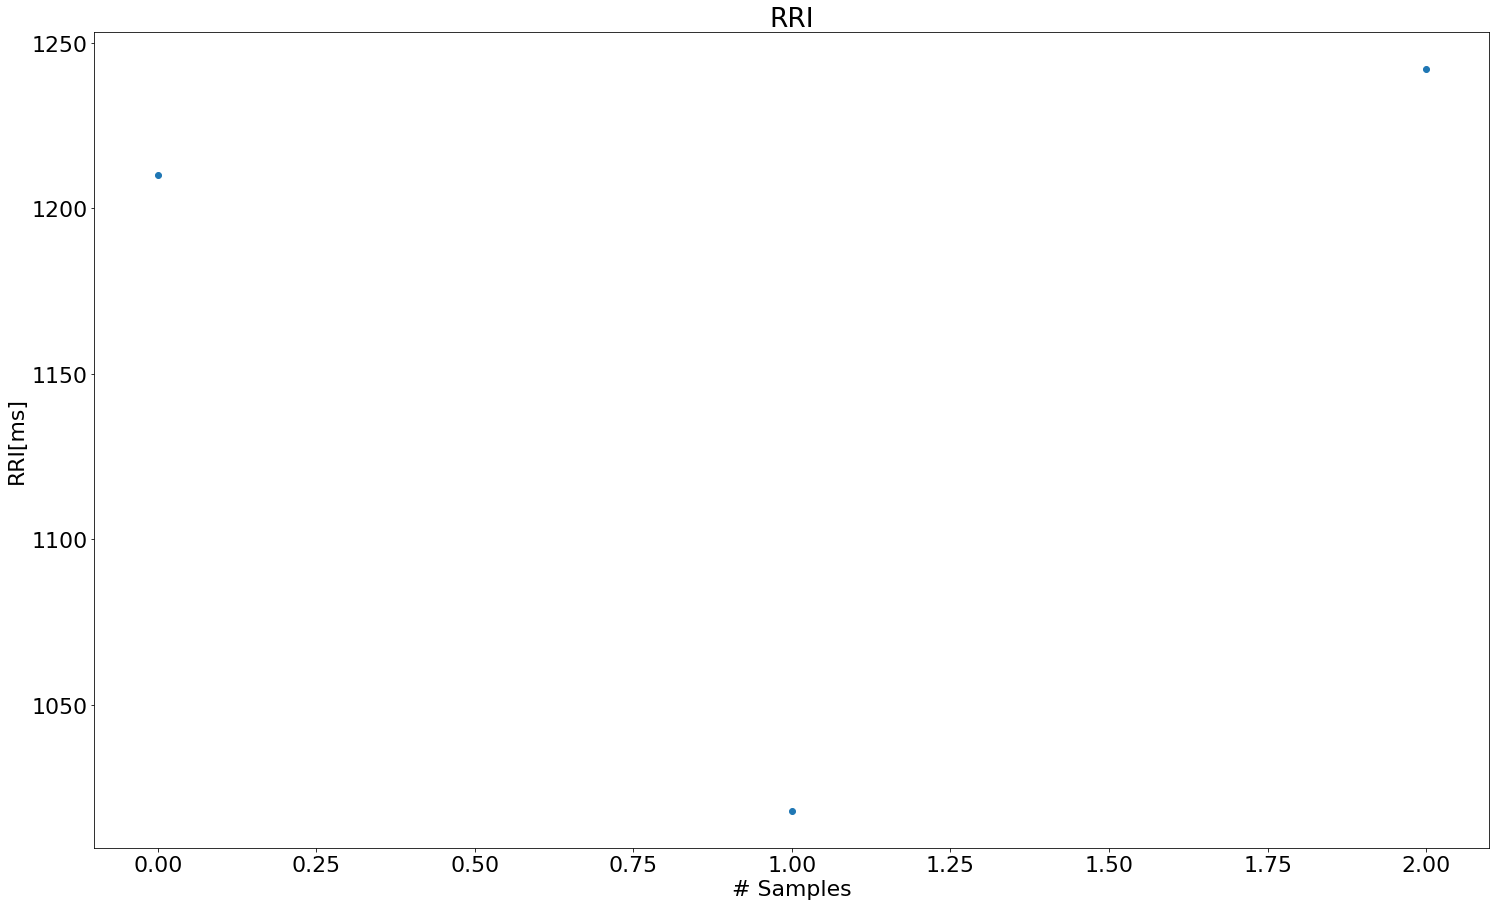

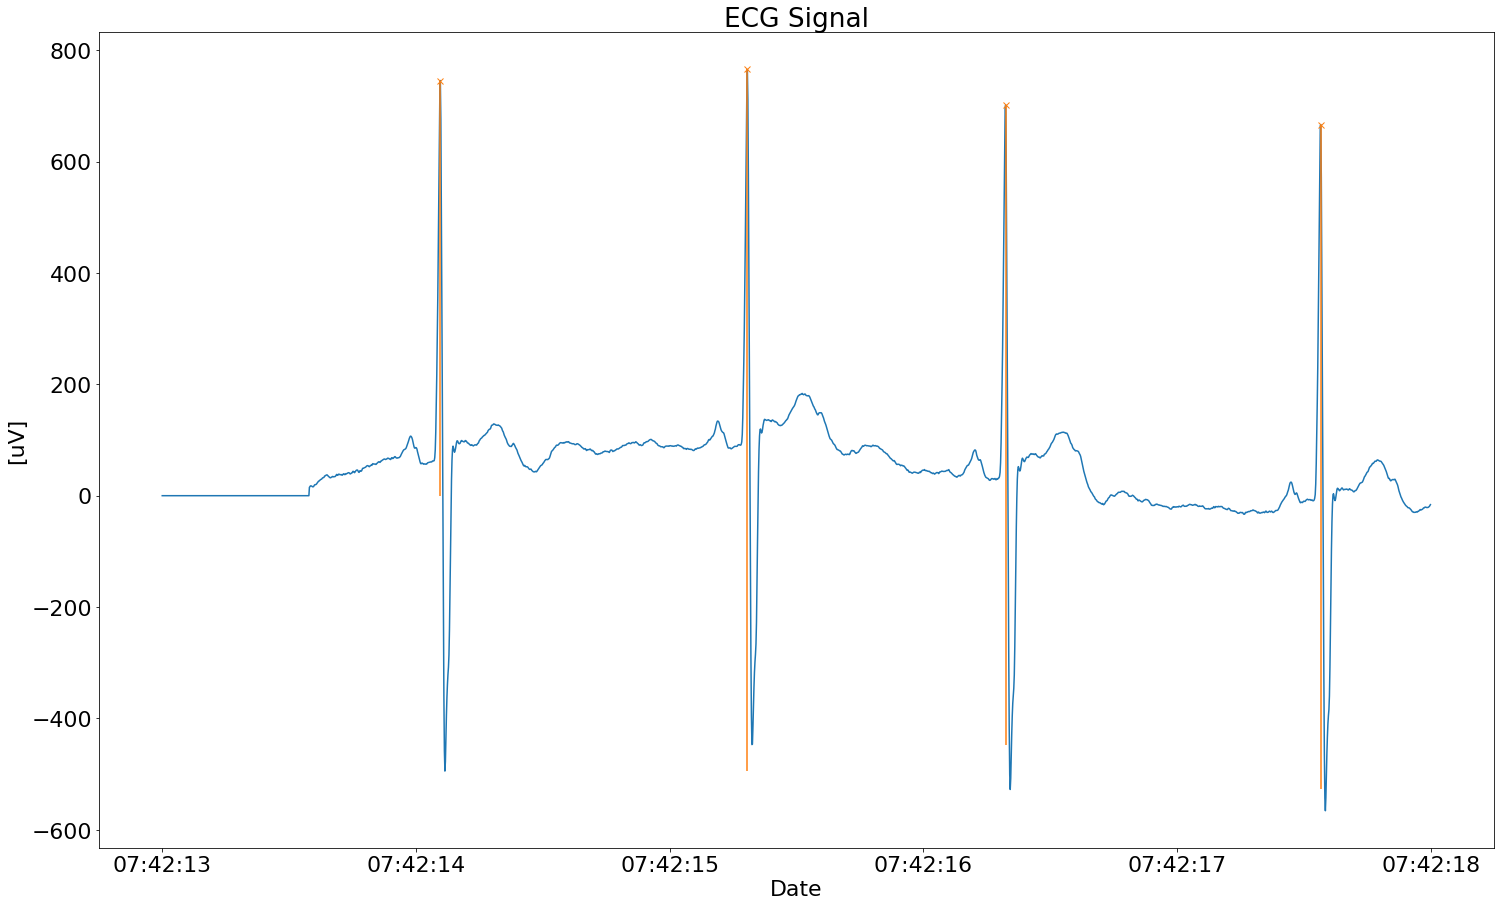

In [20]:
plotRRIs("2022-07-01 07:42:13", interval=5000)

### Histograma de los RRI

Histograma para ver la concentracion de puntos RRI en intervalo de tiempo
eje x = tiempo del RRI
eje y = cantidad de RRI

(array([7.0280e+03, 4.2194e+04, 1.1400e+02, 3.7000e+01, 1.4000e+01,
        4.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   0. ,  767.8, 1535.6, 2303.4, 3071.2, 3839. , 4606.8, 5374.6,
        6142.4, 6910.2, 7678. ]),
 <BarContainer object of 10 artists>)

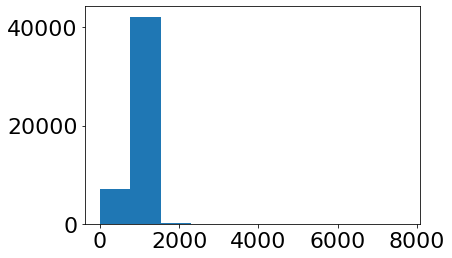

In [21]:
plt.hist(RRIs)

{'whiskers': [<matplotlib.lines.Line2D at 0x1313b2c20>,
 'caps': [<matplotlib.lines.Line2D at 0x1313b31c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1313b2950>],
 'medians': [<matplotlib.lines.Line2D at 0x1313b3760>],
 'fliers': [<matplotlib.lines.Line2D at 0x1313b3a30>],
 'means': []}

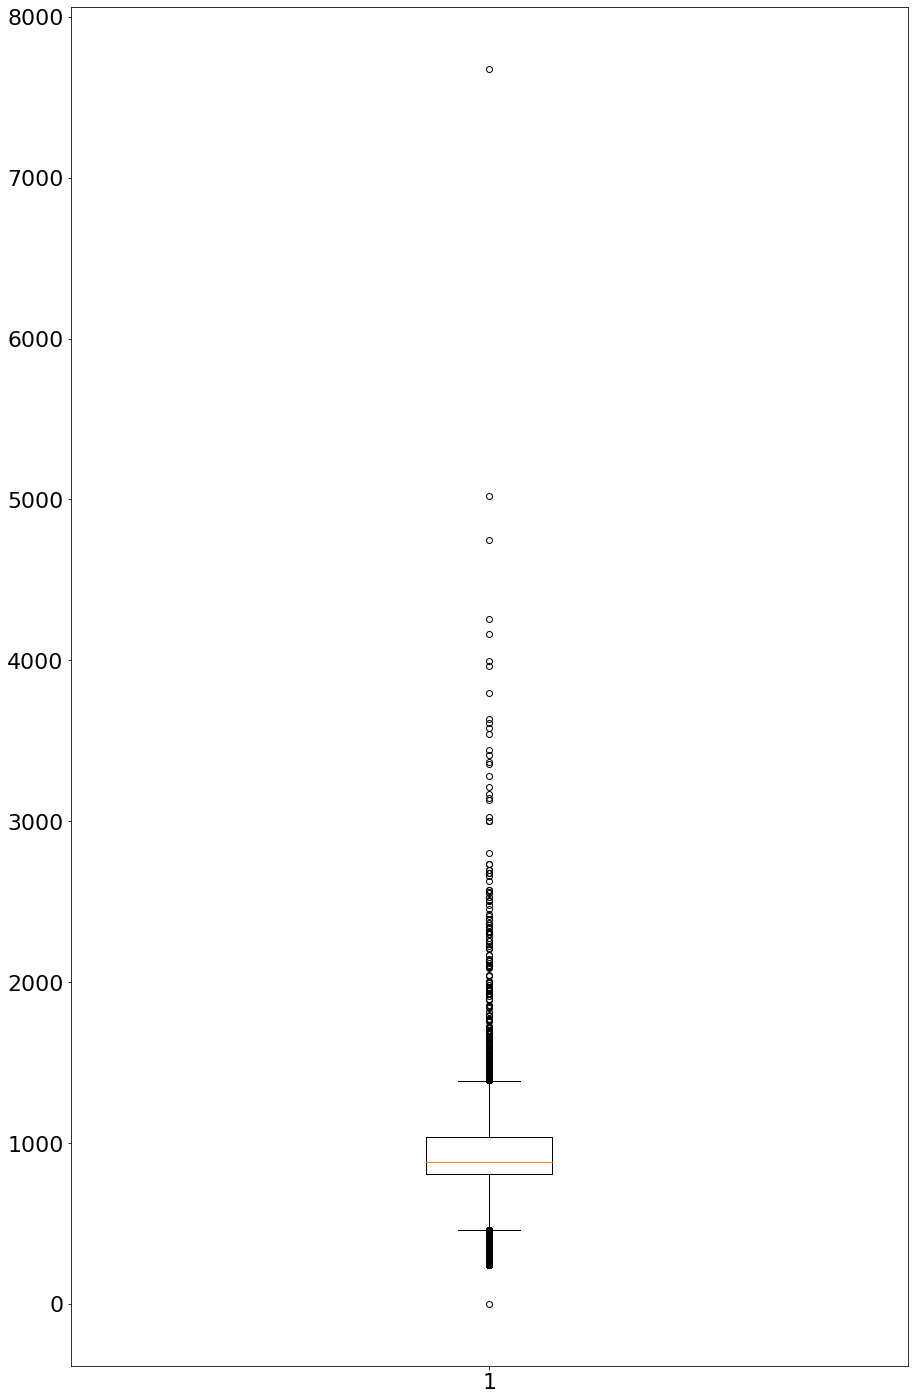

In [22]:
plt.figure(figsize=(15,25))  
plt.boxplot(RRIs)

In [23]:
data.describe()

,ECG,Seizure,RRI
count,2.308550e+07,23085500.0,2.308550e+07
mean,1.388714e-02,0.0,2.103589e-01
std,3.117037e+02,0.0,1.536199e+01
min,-4.167290e+03,0.0,0.000000e+00
25%,-3.267000e+01,0.0,0.000000e+00
50%,3.170000e+00,0.0,0.000000e+00
75%,4.769000e+01,0.0,0.000000e+00
max,4.265280e+03,0.0,1.276000e+03


## Revisión Valor Anomalo 1

El primer valor anomalo es un RRI de 7676.0 en el se aprecia que el sensor de pulso debio ser desconectado entre los tiempos 07:42:06.738 y 07:42:13.580 debido a que registró 0.00,

En el las mediciones tiene una marca IMP-CHECK ON e IMP-CHECK-OFF

10000


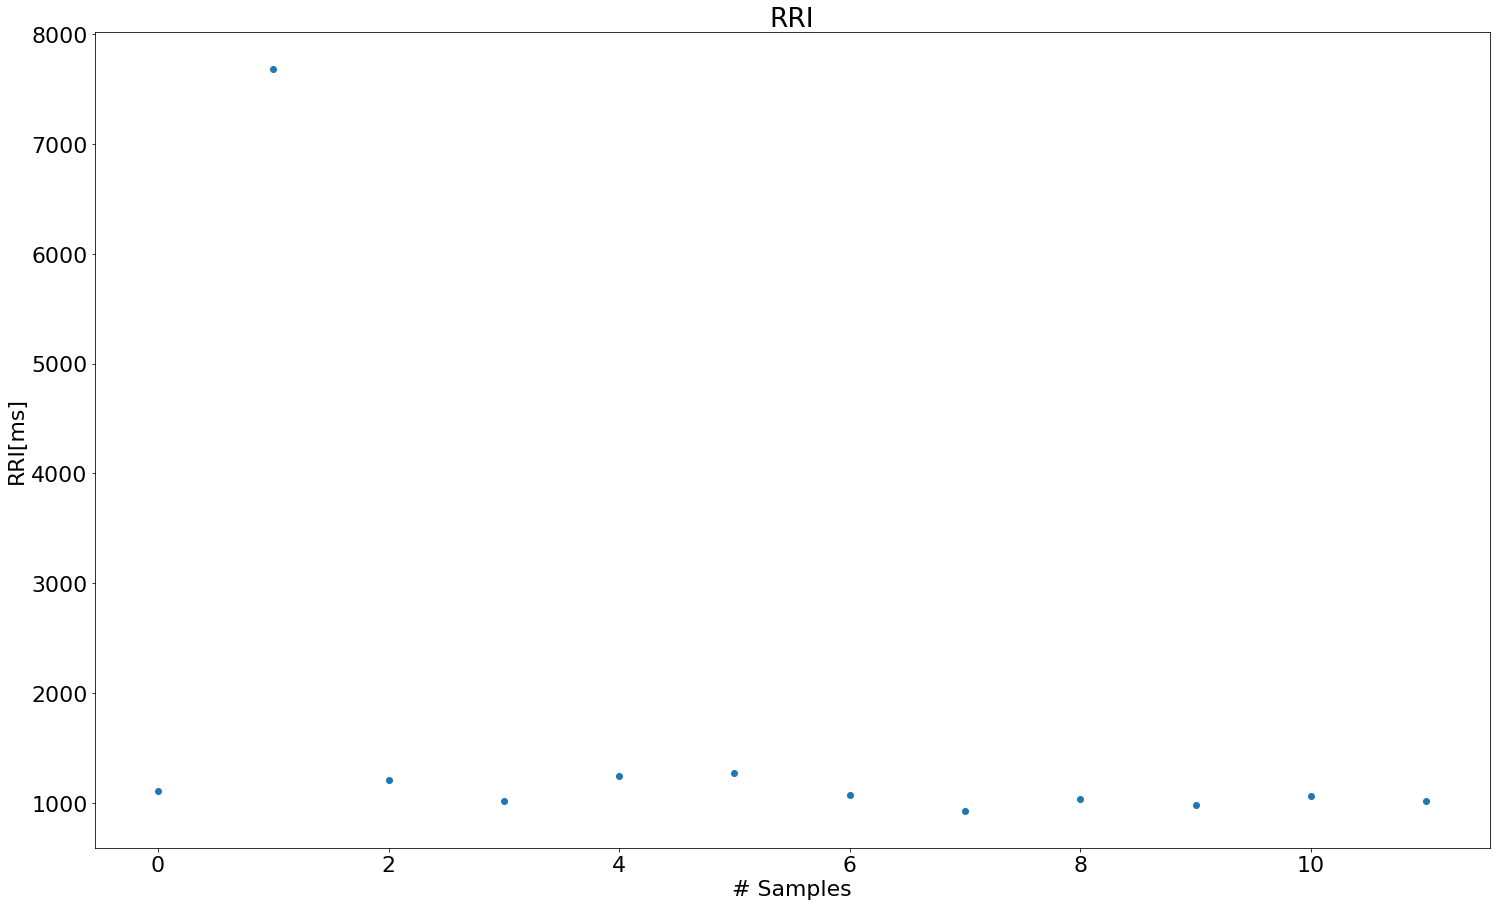

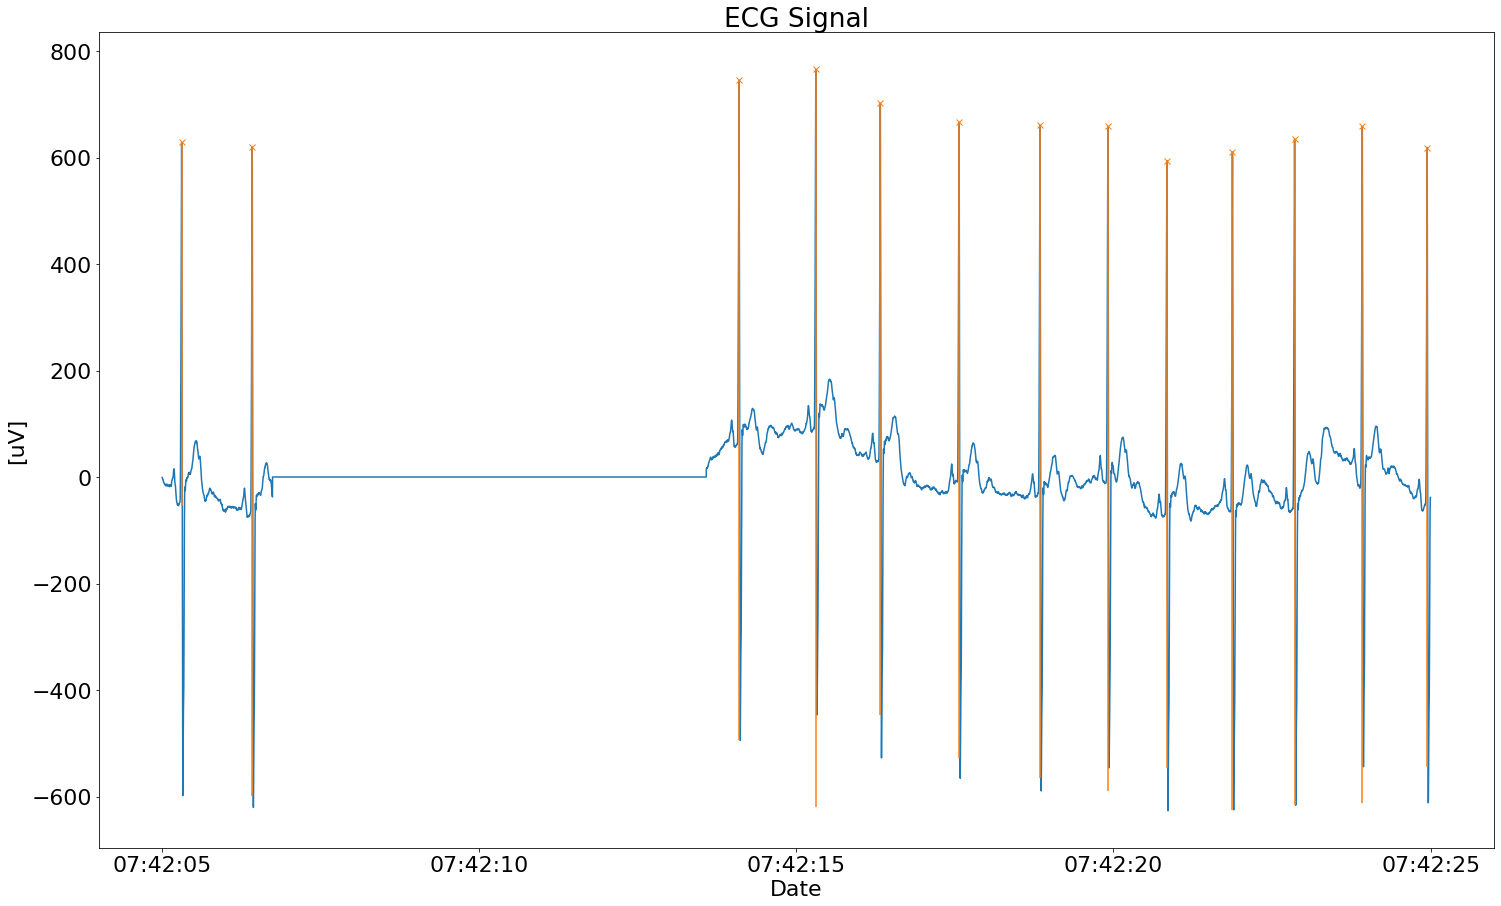

In [24]:
plotRRIs("2022-07-01 07:42:05.000000",interval= 20000)

## Revisión Valor Anomalo 2

El primer valor anomalo es un RRI de 5500.0 

2500


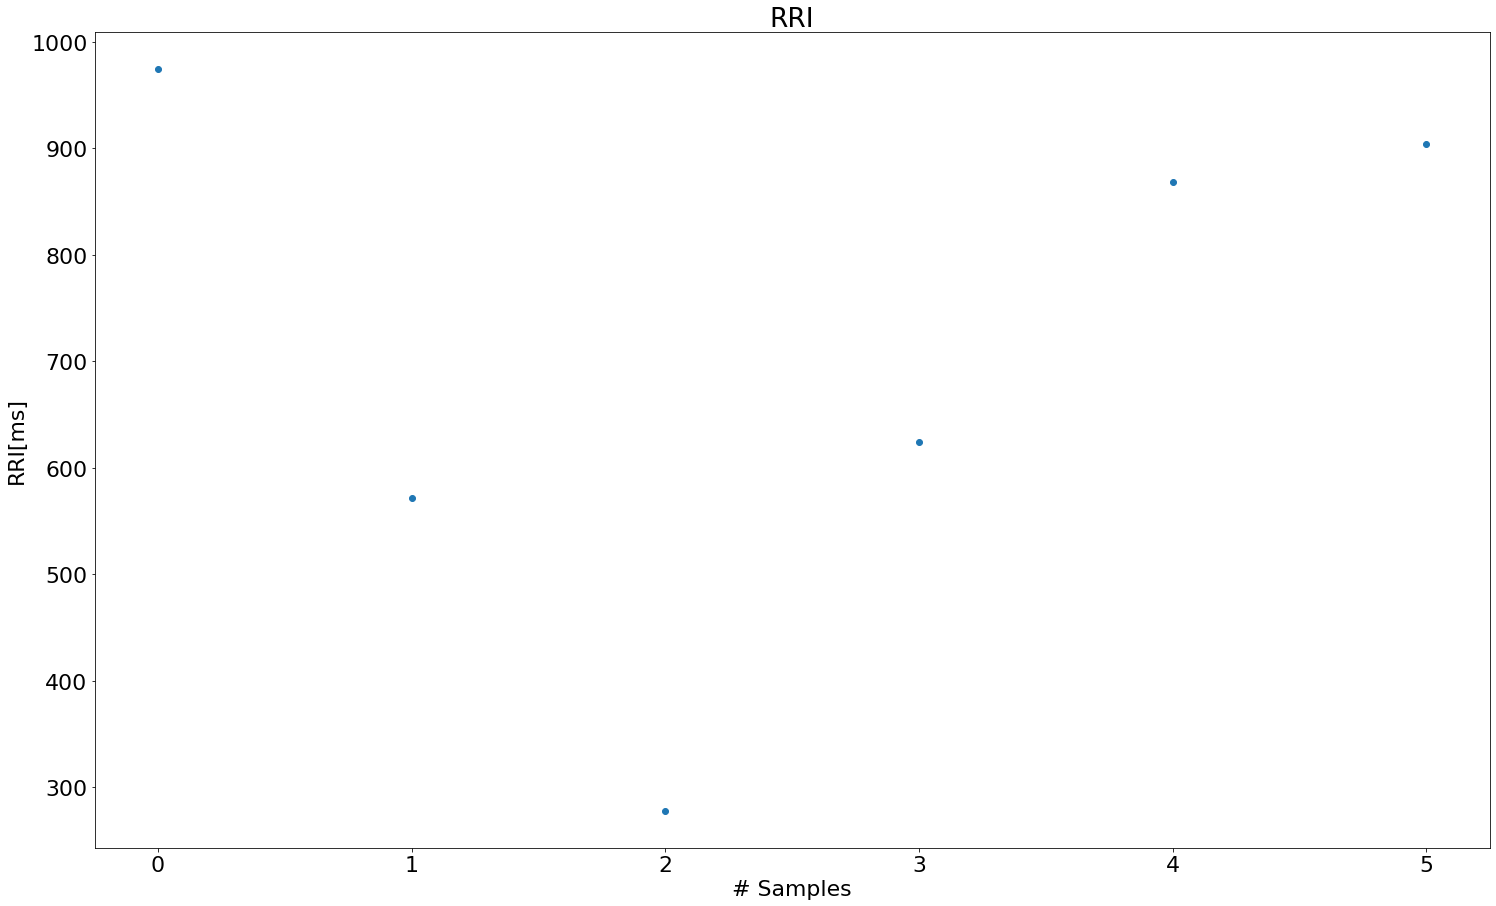

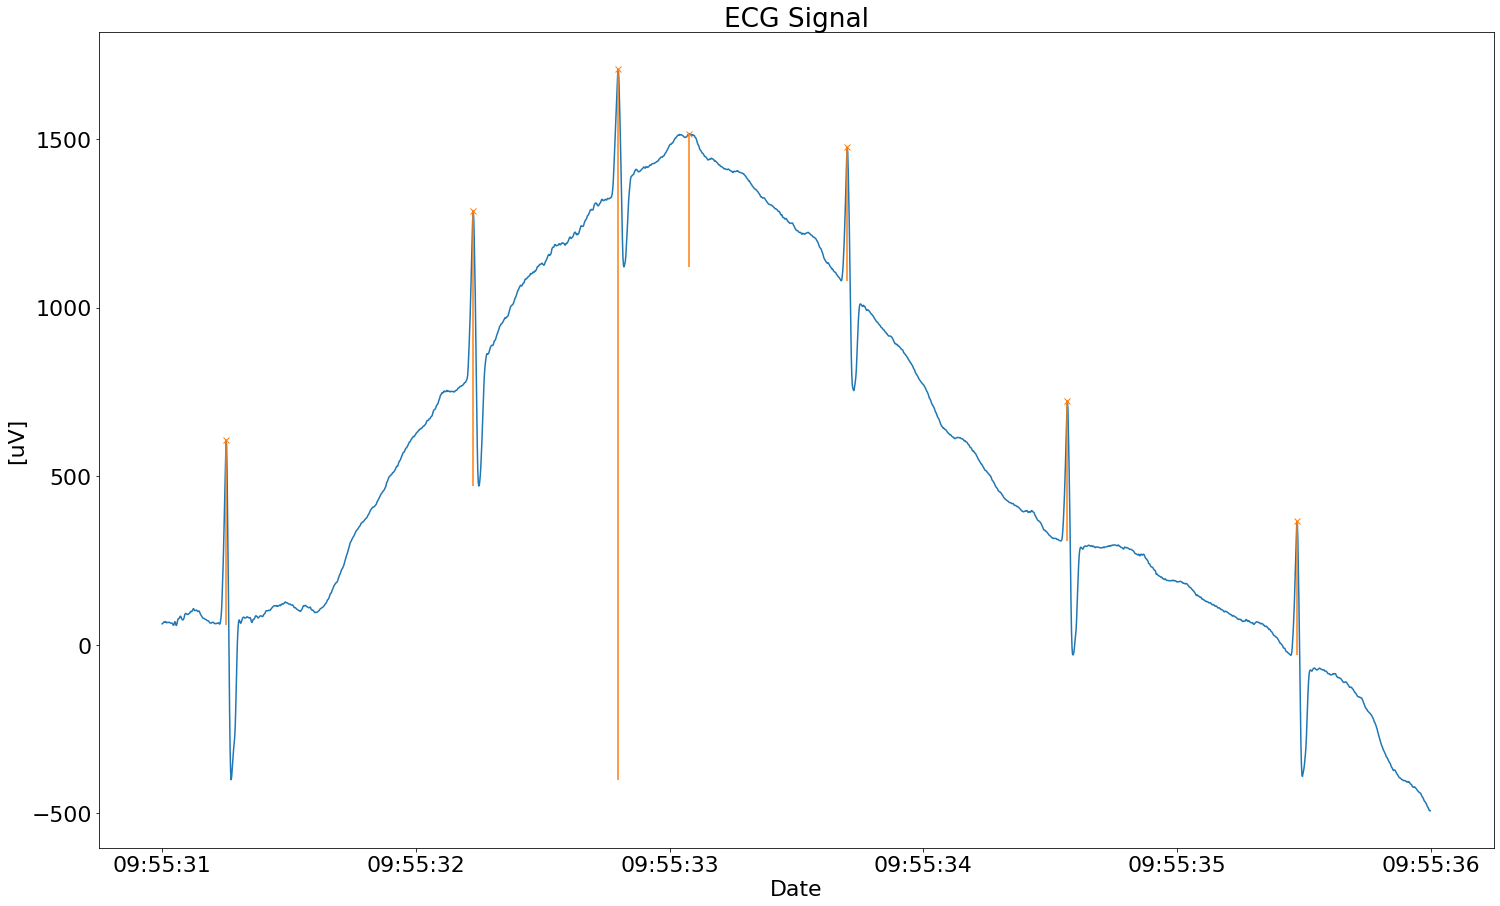

In [25]:
plotRRIs("2022-07-01 09:55:31.000",interval= 5000)

## Crisis 1

La crisis se marca en el programa desde las 7:51:51 hasta las 7:51:59 intervalo de 8 segundos, pero se ven anomalias en la frecuencia cardiaca mas alla de este tiempo

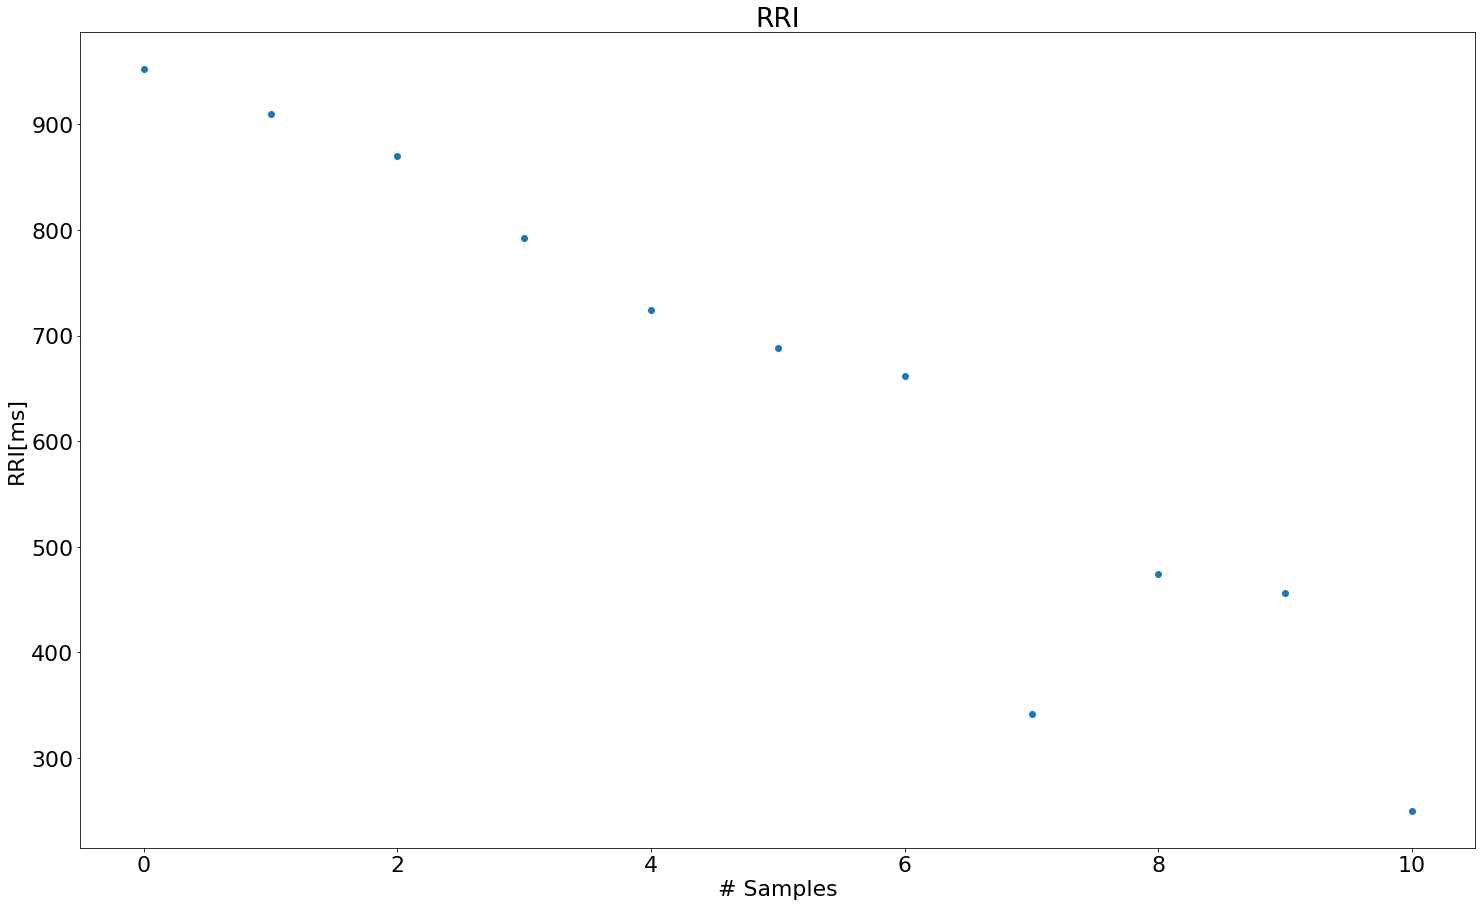

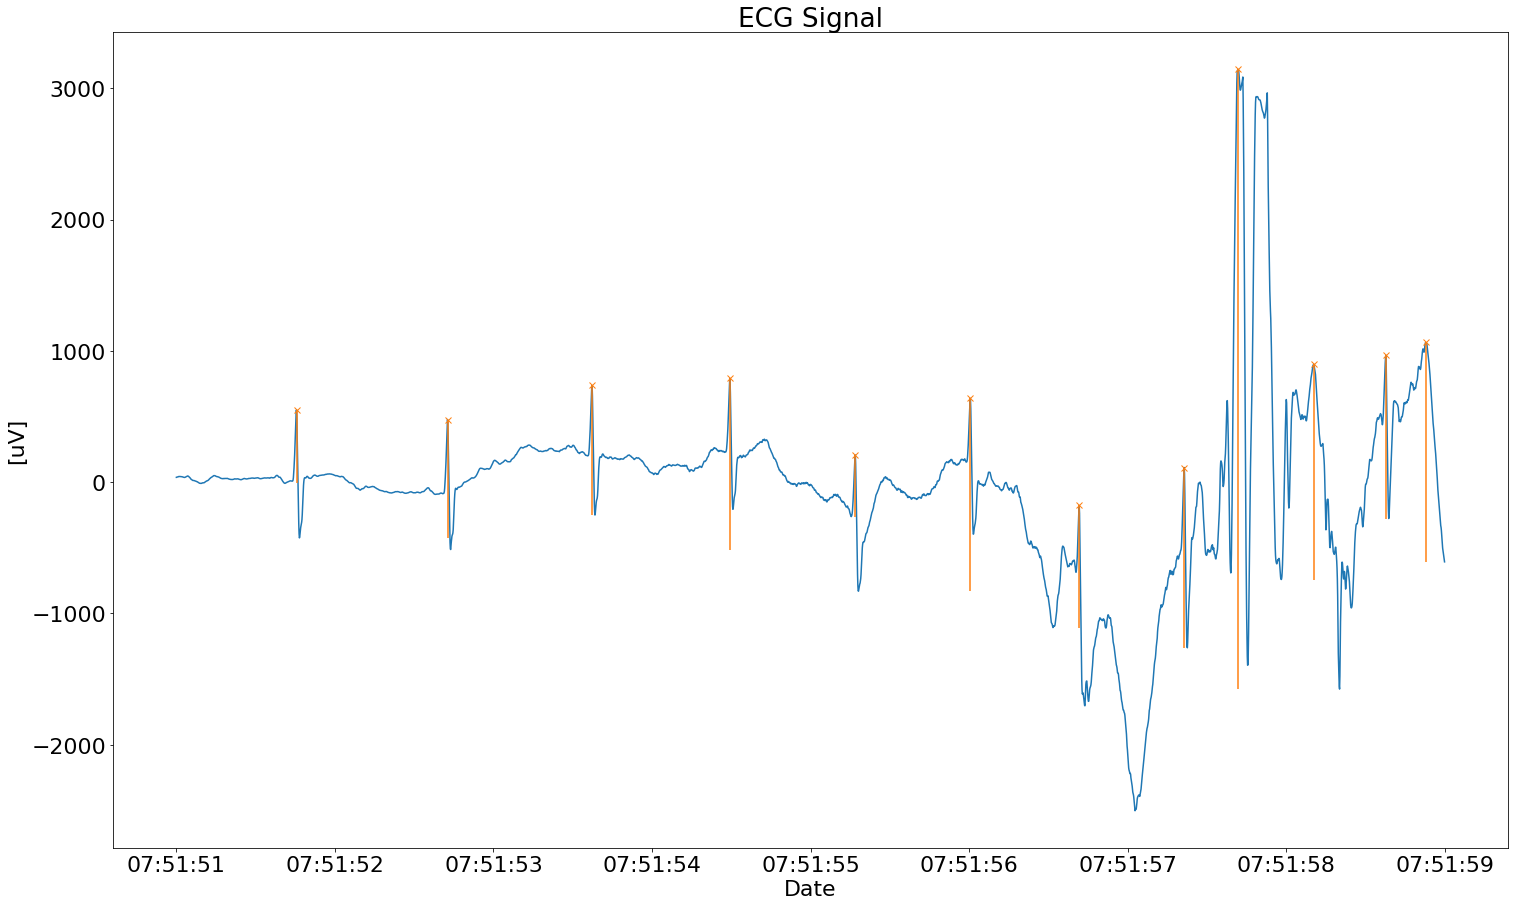

In [72]:
plotRRIs("2022-07-01 07:51:51.000000", "2022-07-01 07:51:59.000000")
putSeilzure(data,"2022-07-01 07:51:51.000000", "2022-07-01 07:51:59.000000")

## Crisis 2

La crisis se marca en el programa desde las 7:57:59 hasta las 7:58:08 intervalo de  9 segundos



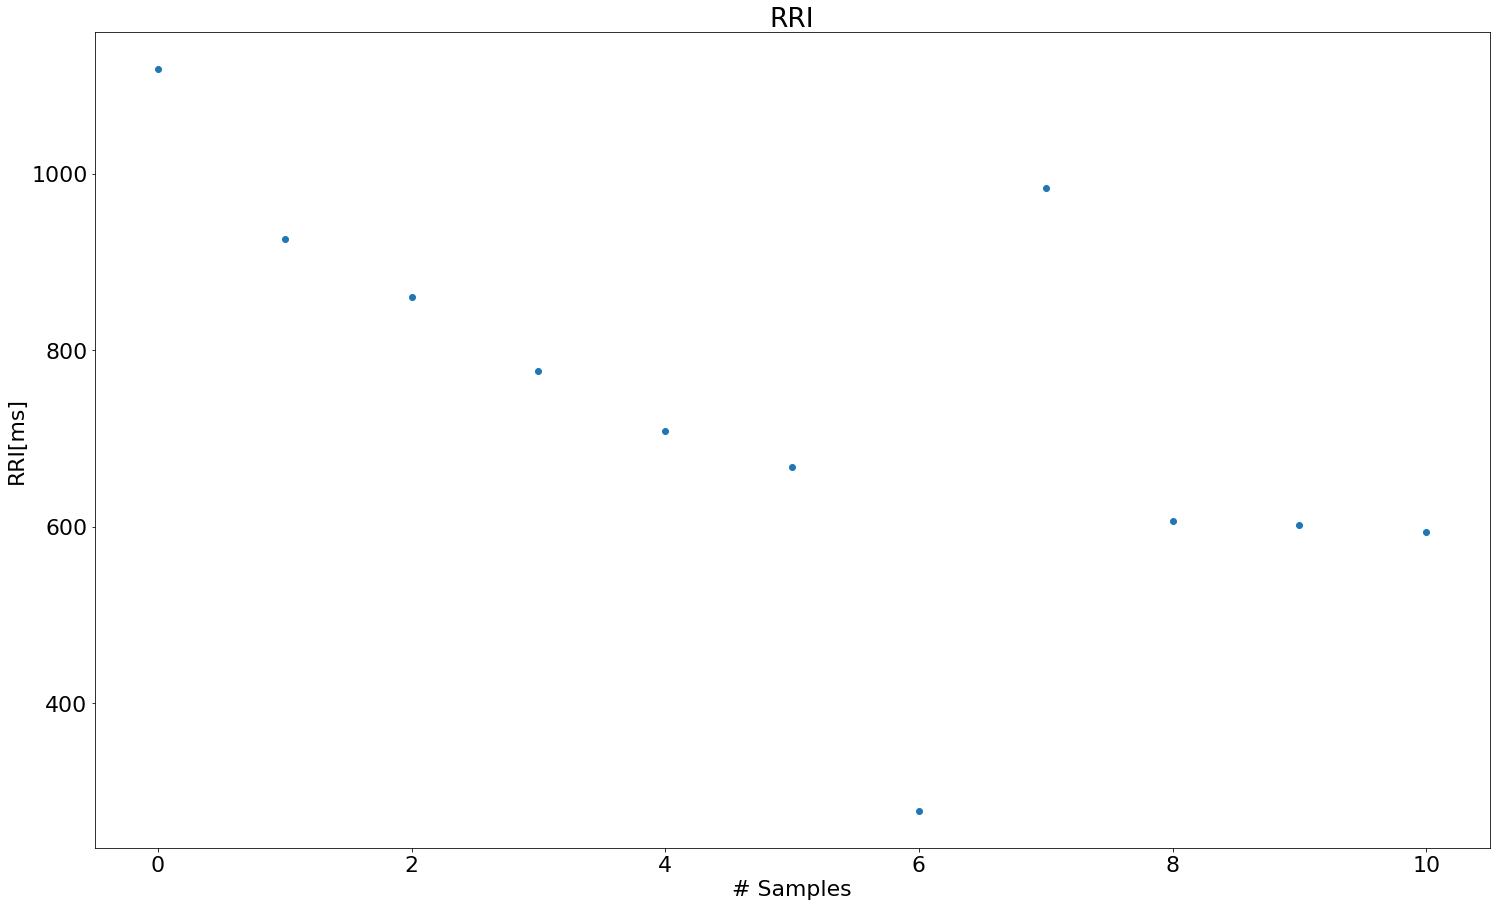

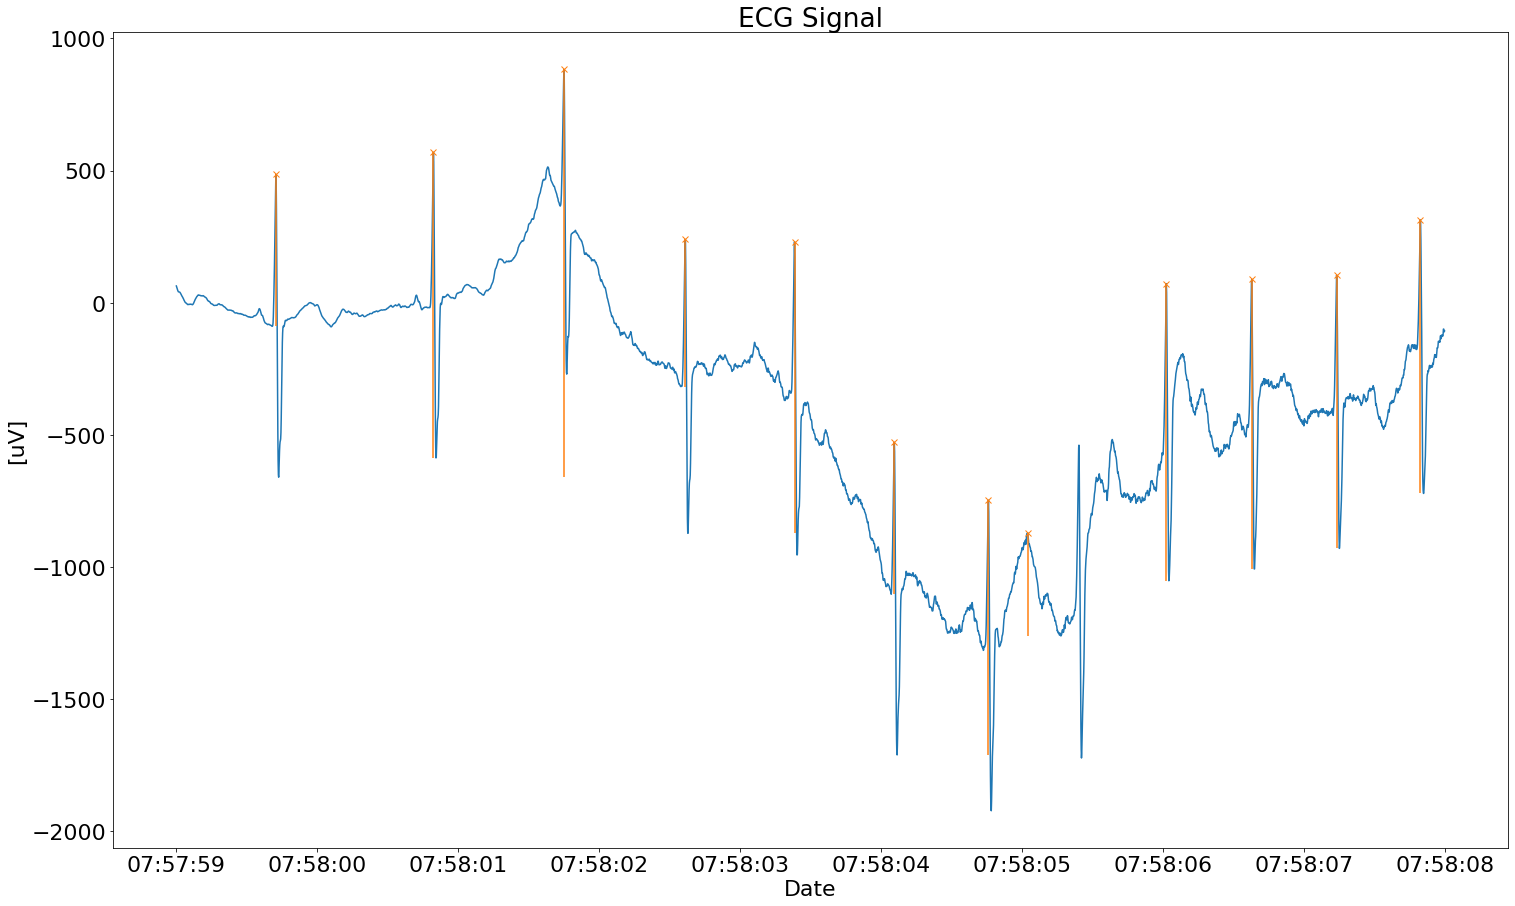

In [73]:
plotRRIs("2022-07-01 07:57:59.000000", "2022-07-01 07:58:08.000000")
putSeilzure(data,"2022-07-01 07:57:59.000000", "2022-07-01 07:58:08.000000")

## Crisis 3

La crisis se marca en el programa desde las 08:00:17 hasta las 8:00:25 intervalo de 

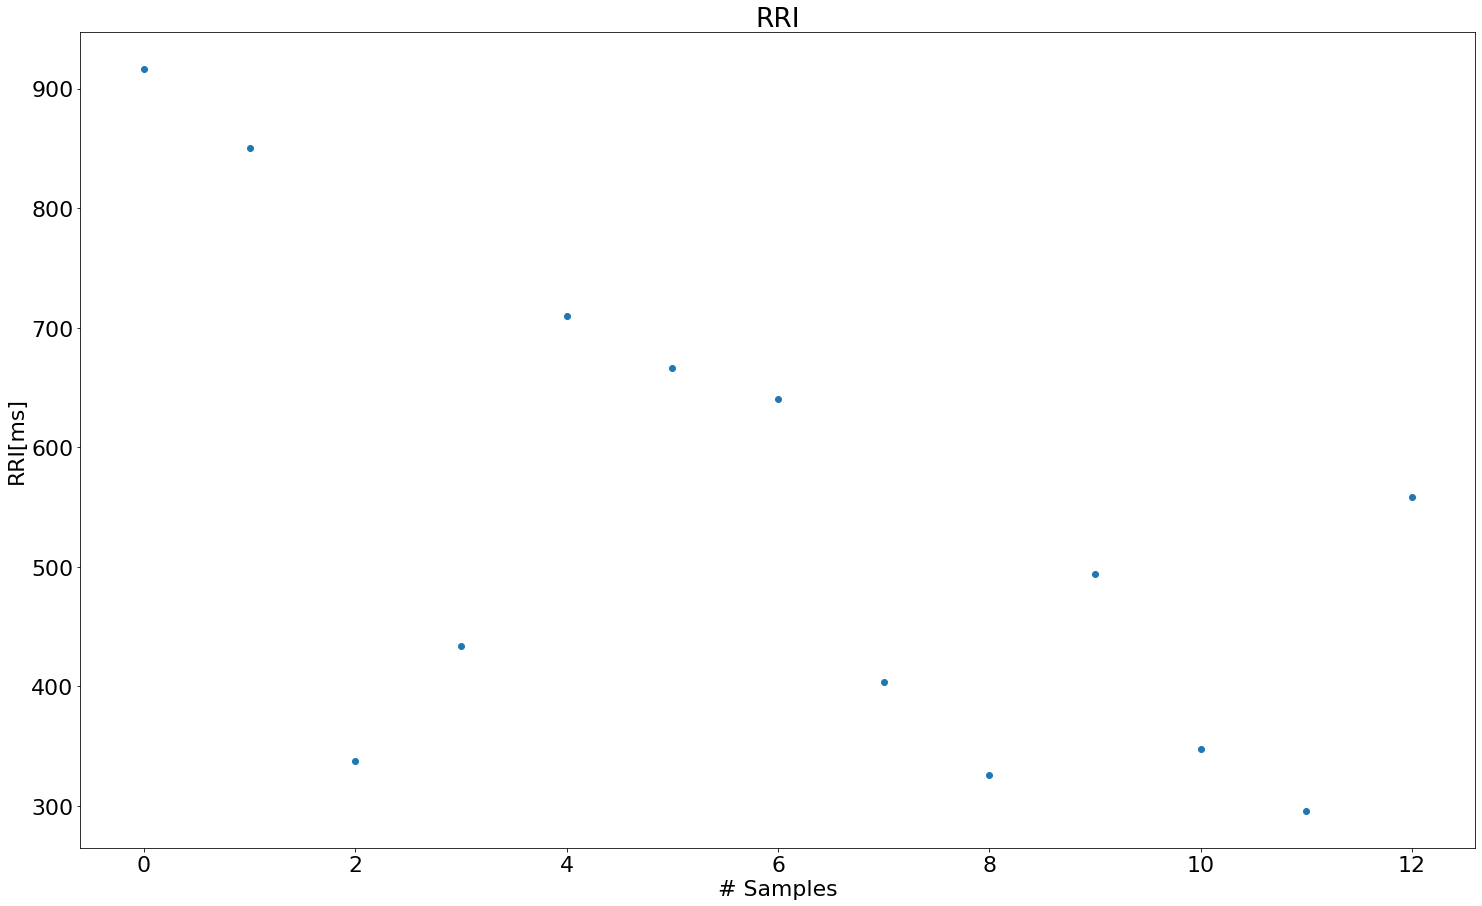

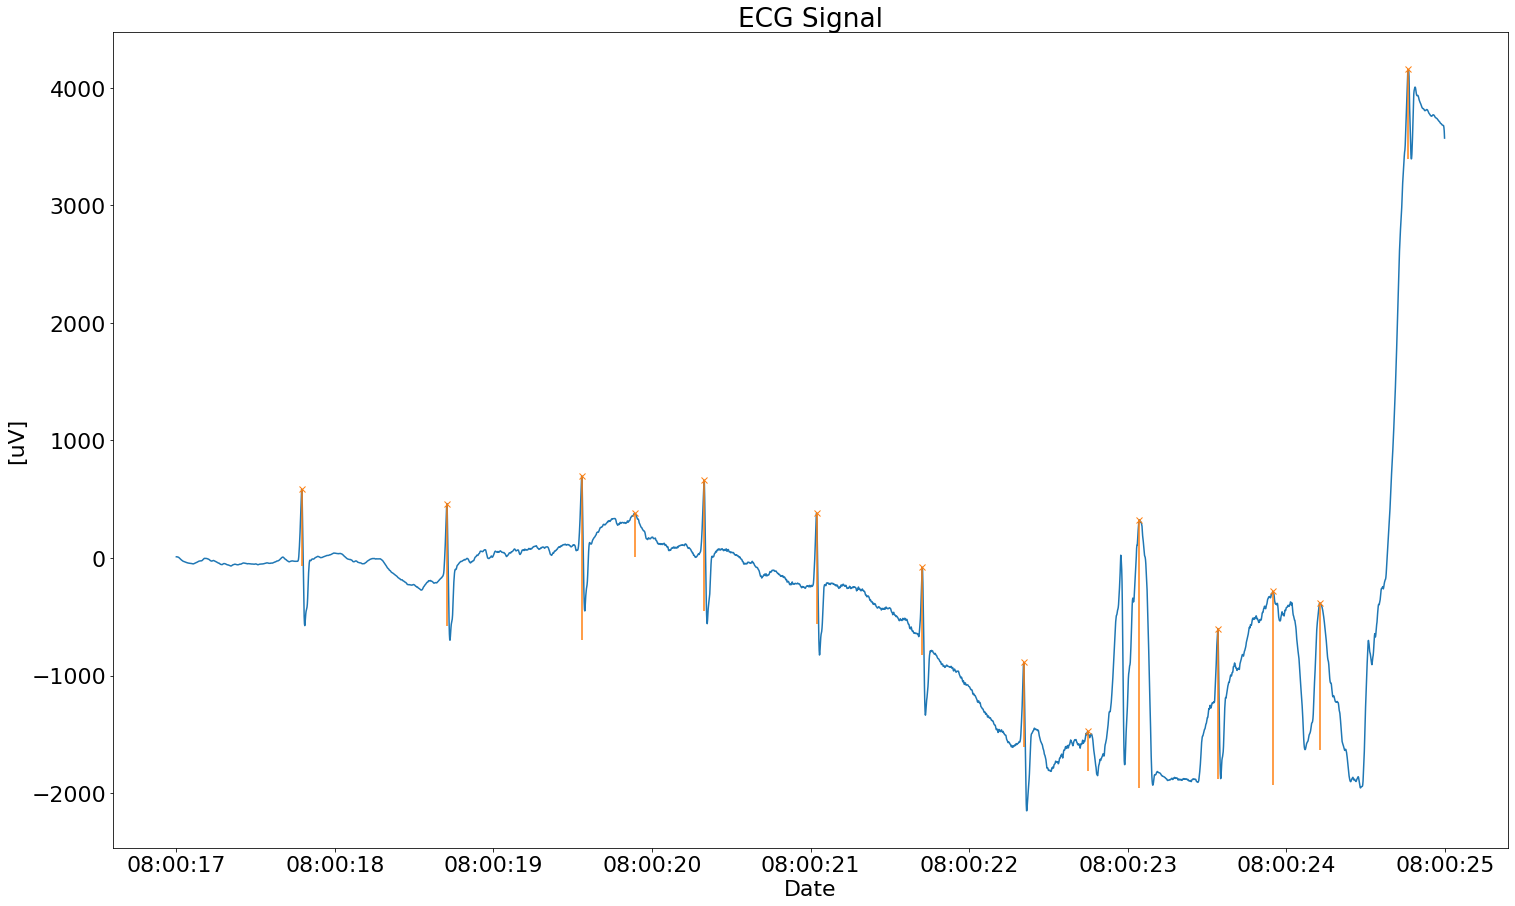

In [74]:
plotRRIs("2022-07-01 08:00:17.000000", "2022-07-01 08:00:25.000000")
putSeilzure(data,"2022-07-01 08:00:17.000000", "2022-07-01 08:00:25.000000")

## Crisis 4

La crisis se marca en el programa desde las 08:03:42 hasta las 8:03:53 intervalo de 

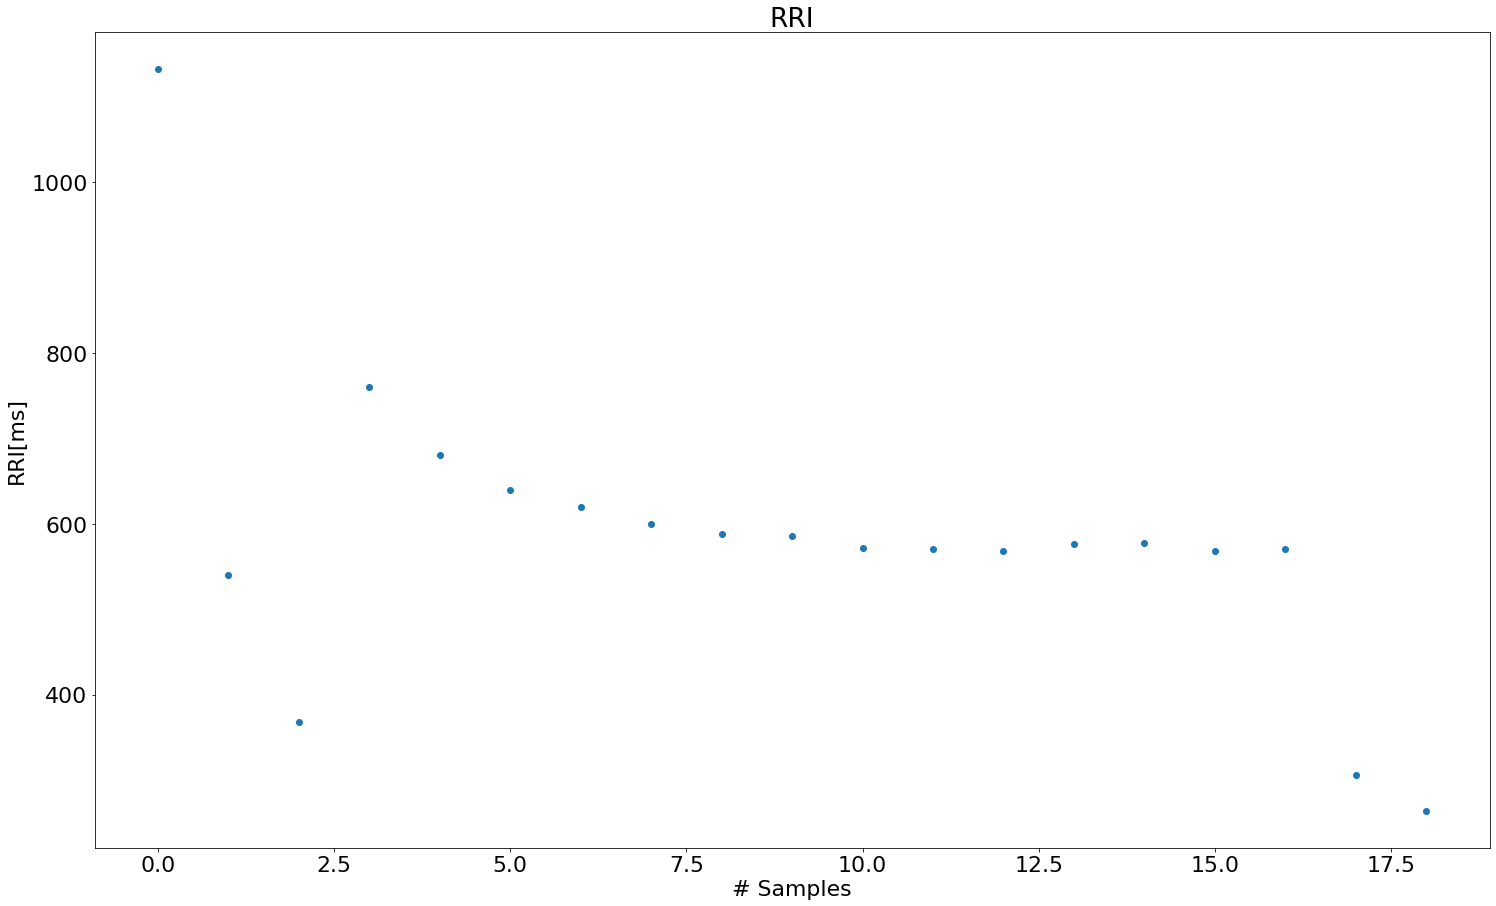

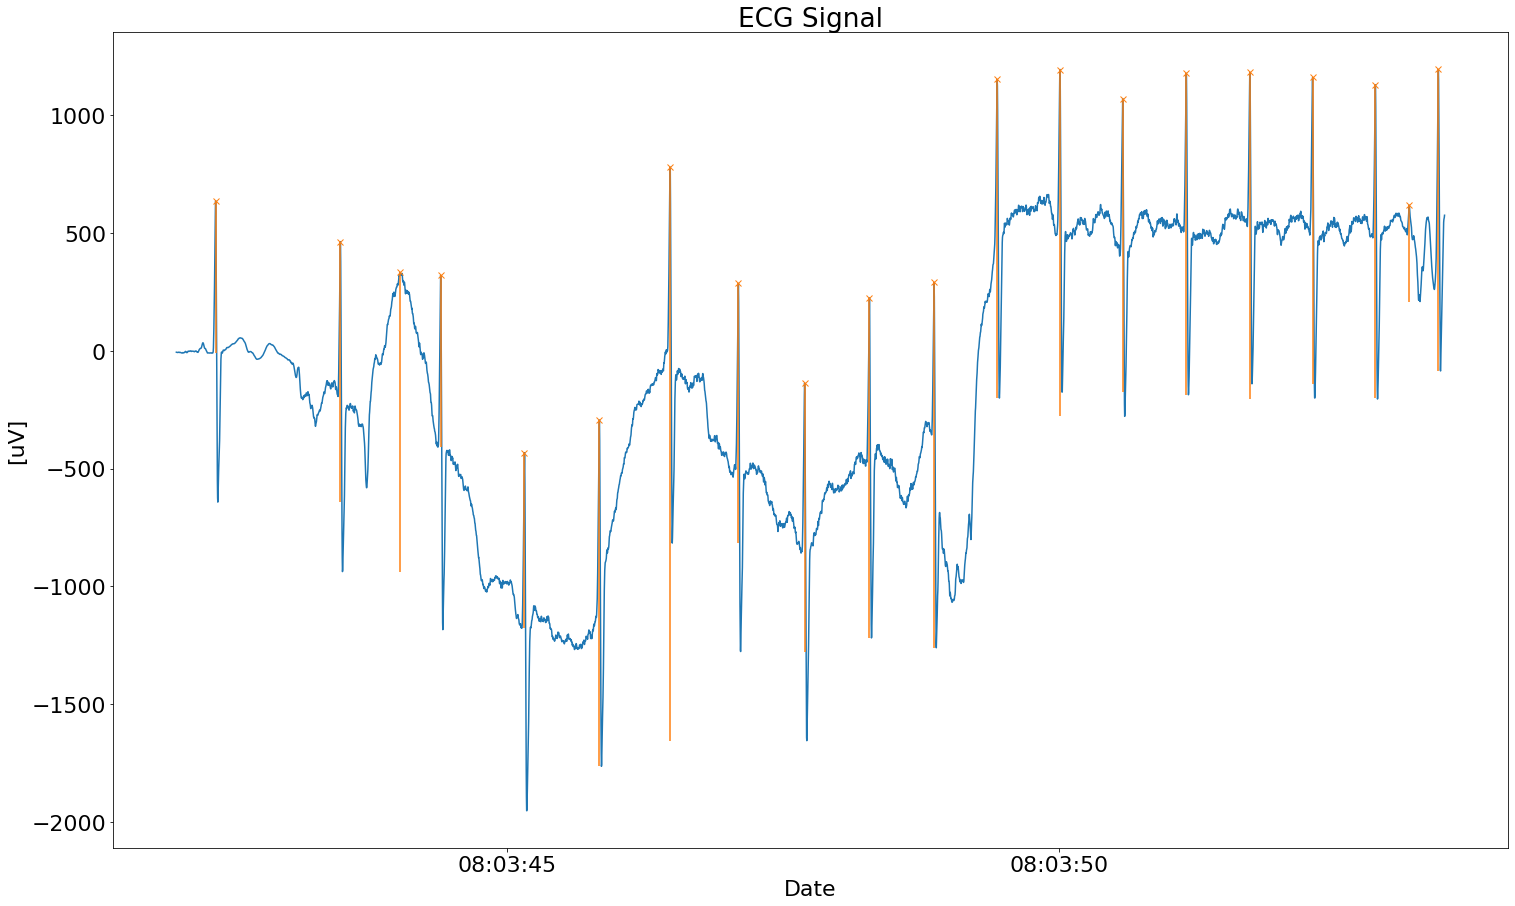

In [75]:
plotRRIs("2022-07-01 08:03:42.000000", "2022-07-01 08:03:53.500000")
putSeilzure(data,"2022-07-01 08:03:42.000000", "2022-07-01 08:03:53.500000")

## Crisis 5

La crisis se marca en el programa desde las 12:29:35 hasta las 12:29:47 intervalo de 12 segundos 

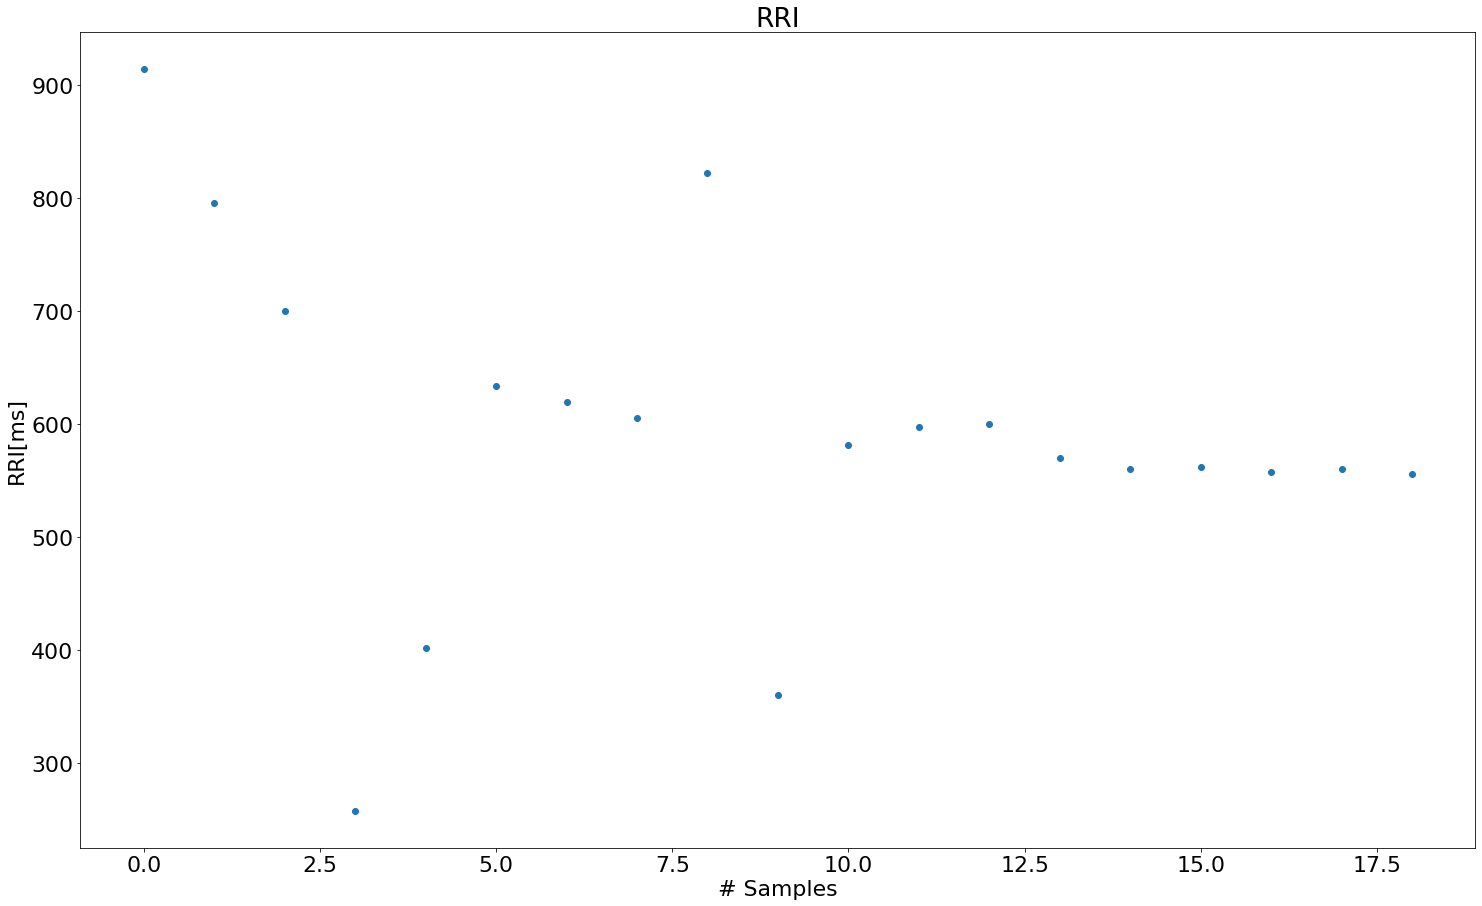

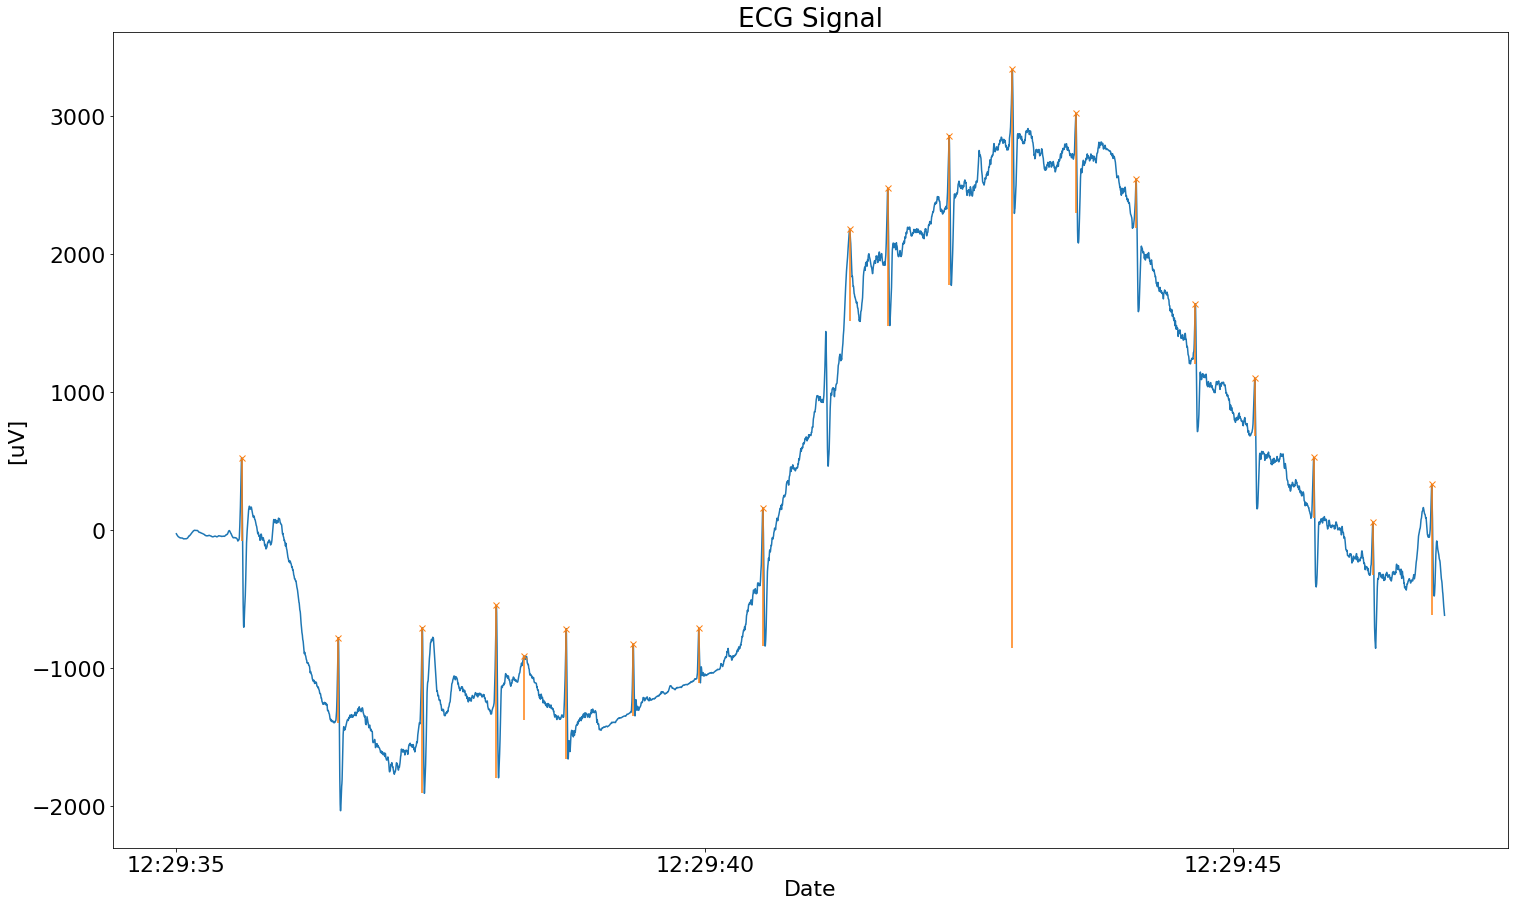

In [76]:
plotRRIs("2022-07-01 12:29:35.000000", "2022-07-01 12:29:47.000000")
putSeilzure(data,"2022-07-01 12:29:35.000000", "2022-07-01 12:29:47.000000")

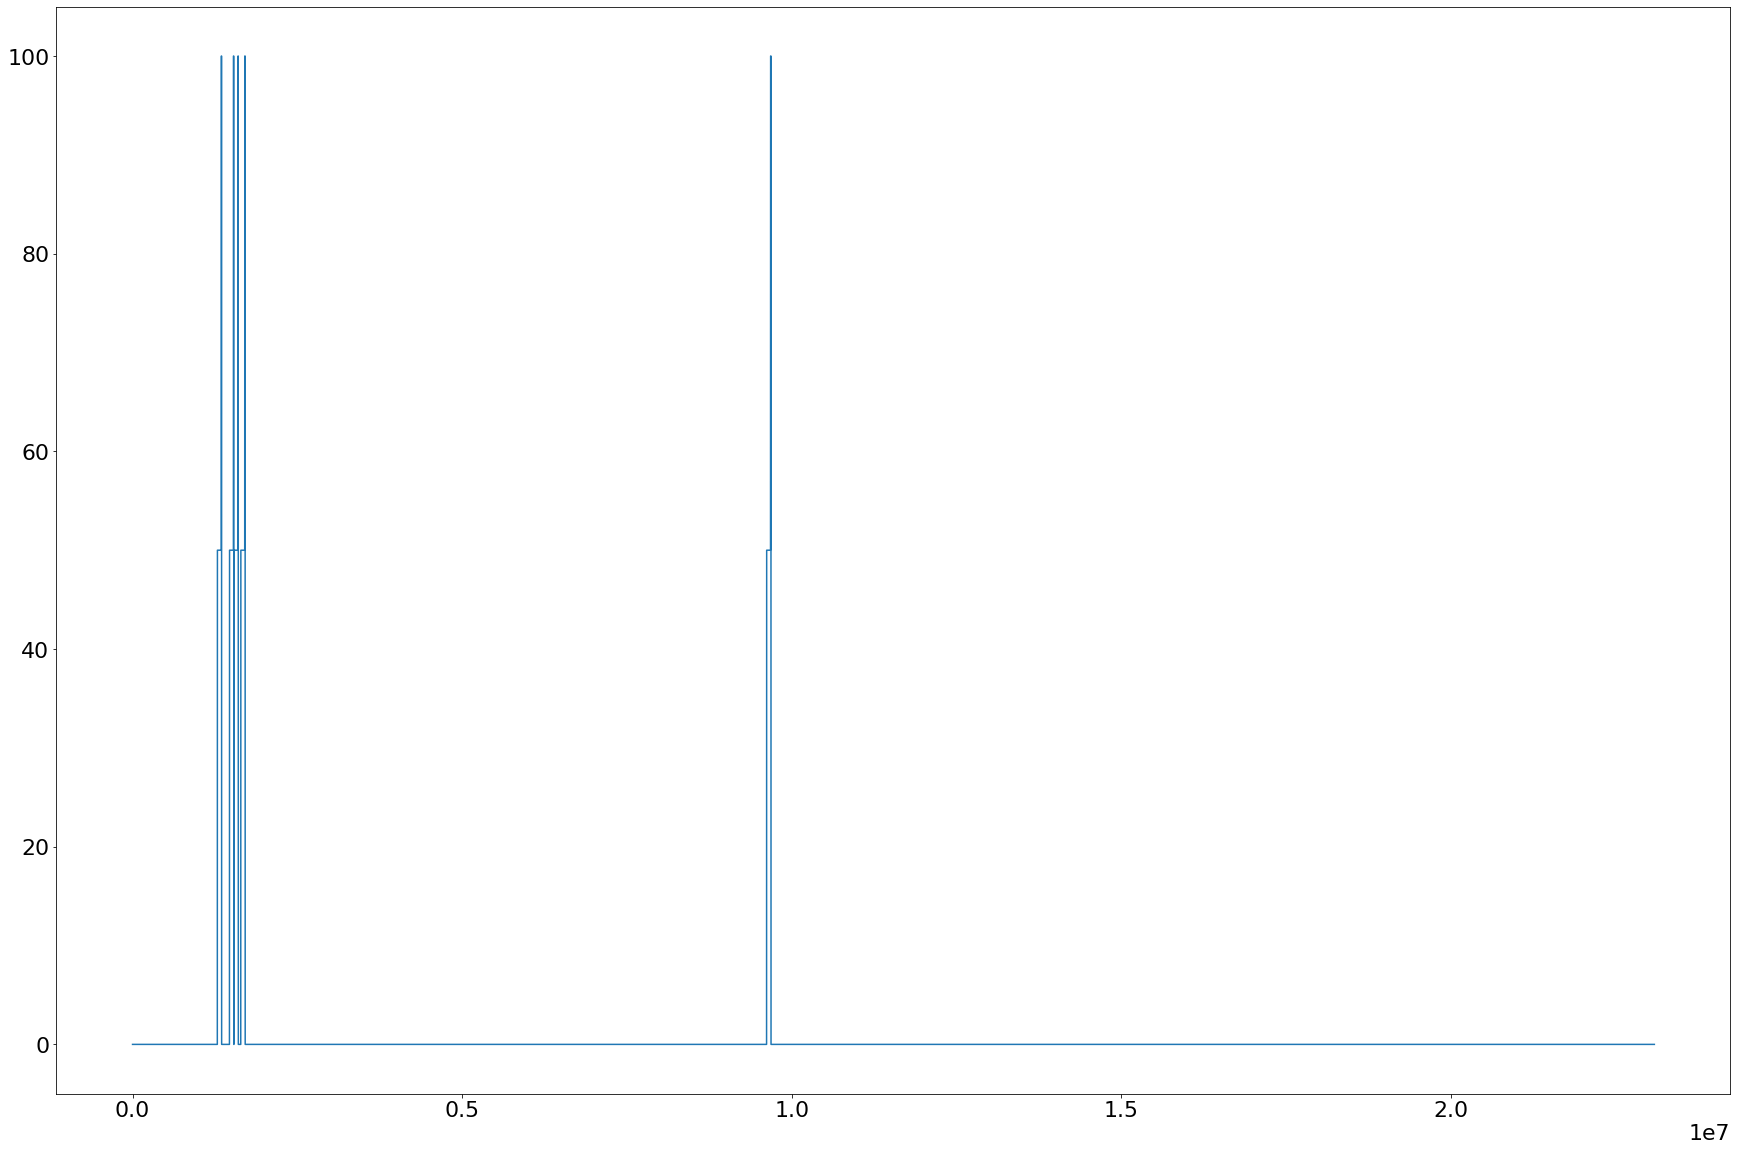

In [20]:
plt.figure(figsize=(30,20))
plt.plot(data["Seizure"])

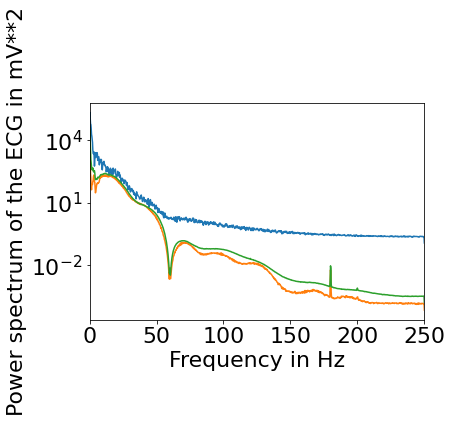

In [21]:
#Frecuencia de la señal por cada clase

from scipy.signal import welch
fs = 500
f, Pxx = welch(data["ECG"][data["Seizure"]==1000], fs=fs, nperseg=2048, scaling="spectrum")
plt.semilogy(f, Pxx)#Azul
f, Pxx = welch(data["ECG"][data["Seizure"]==500], fs=fs, nperseg=2048, scaling="spectrum")
plt.semilogy(f, Pxx)#Naranja
f, Pxx = welch(data["ECG"][data["Seizure"]==0], fs=fs, nperseg=2048, scaling="spectrum")
plt.semilogy(f, Pxx)#Verde
plt.xlabel("Frequency in Hz")
plt.ylabel("Power spectrum of the ECG in mV**2")
plt.xlim(f[[0, -1]])
plt.show()

# Construir el Dataset de utilidad

Ahora se va a construir un dataset con las verdaderas variables predictoras

en principio es el parametro RRI por lo que tengo que dividir la señal en intervalos para sacar esos parametros


In [16]:
data.head()

,ECG,Time,Seizure,RRI
0,0.0,2022-07-01 07:06:59.000,0,0
1,0.0,2022-07-01 07:06:59.002,0,0
2,0.0,2022-07-01 07:06:59.004,0,0
3,0.0,2022-07-01 07:06:59.006,0,0
4,0.0,2022-07-01 07:06:59.008,0,0


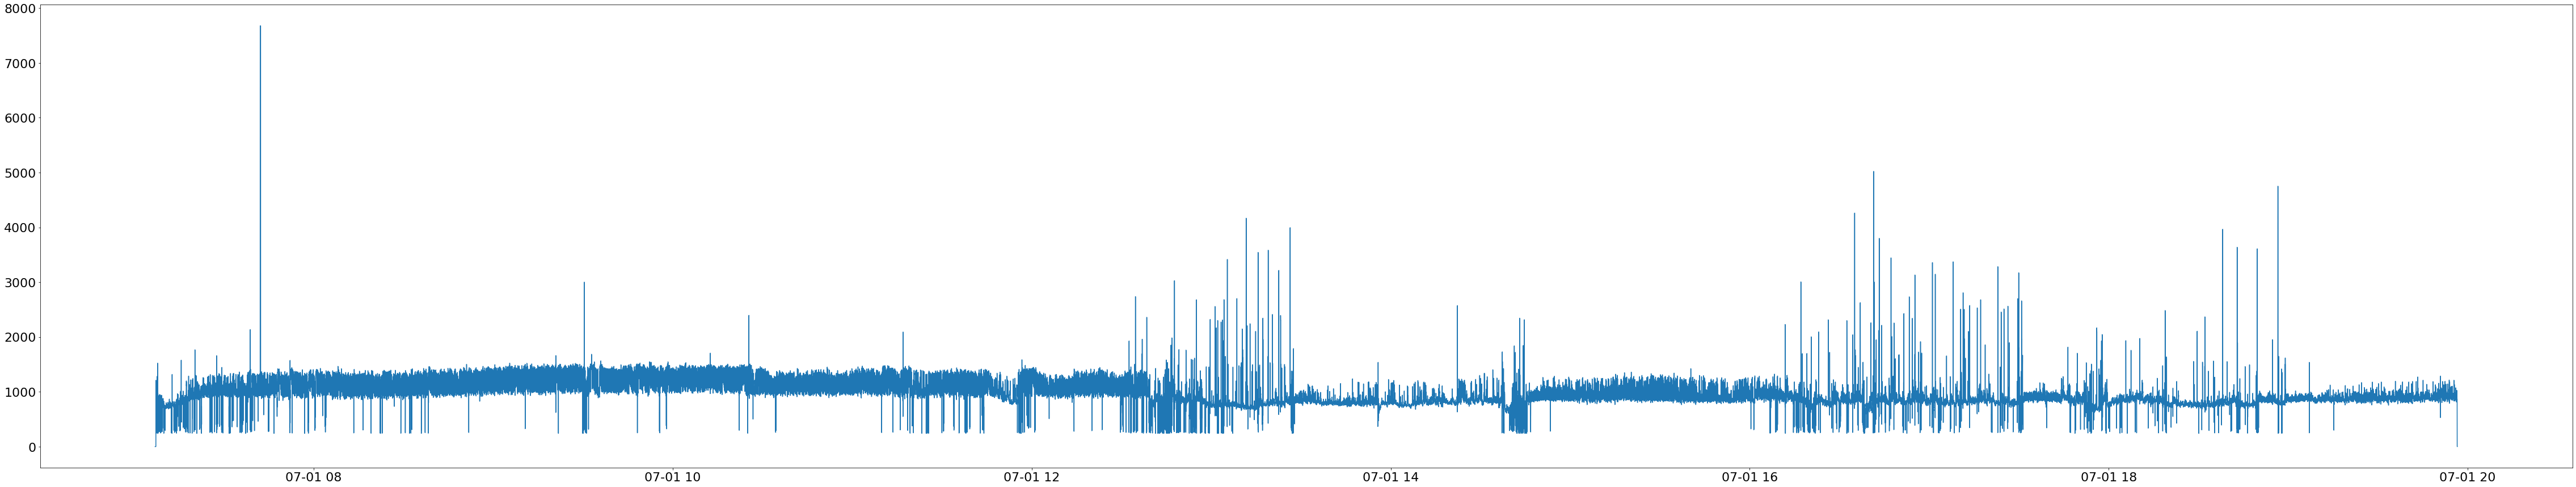

In [22]:
plt.figure(figsize=(80,15))
plt.plot(data["Time"],data["RRI"])

In [23]:
data1 = data[data["Seizure"]==500]
data1

,ECG,Time,Seizure,RRI
1286000,56.40,2022-07-01 07:49:51.000,500,900
1286001,56.71,2022-07-01 07:49:51.002,500,900
1286002,57.52,2022-07-01 07:49:51.004,500,900
1286003,58.02,2022-07-01 07:49:51.006,500,900
1286004,59.31,2022-07-01 07:49:51.008,500,900
...,...,...,...,...
9677995,-4.89,2022-07-01 12:29:34.990,500,964
9677996,-8.47,2022-07-01 12:29:34.992,500,964
9677997,-13.55,2022-07-01 12:29:34.994,500,964
9677998,-17.56,2022-07-01 12:29:34.996,500,964


In [116]:
sampleDf.to_csv(mainpath+"out1.csv")
